# Fine-tuning Custom CNN After SimCLR Pretraining

## Supervised Learning with Pretrained Encoder + Progressive Unfreezing

**Objective**: Fine-tune the SimCLR pretrained custom CNN on EuroSAT for supervised classification and OOD detection.

**Pretrained Encoder**: 
- **Source**: `best_contrastive_model_*.pth` (from `01_simclr_pretrain_custom_cnn_300epochs.ipynb`)
- **Pretraining**: 300 epochs SimCLR on BigEarthNet-S2
- **Architecture**: Custom CNN (4-layer) with learned representations

**Fine-tuning Datasets**:
- **EuroSAT** (In-Distribution): 27,000 labeled images, 10 classes
- **UC Merced** (Out-of-Distribution): 2,100 images, 5 classes used as OOD

**Progressive Unfreezing Strategy** 🌡️:
- **Phase 1 (Epochs 1-10)**: Freeze encoder, train classifier only
- **Phase 2 (Epochs 11-20)**: Unfreeze last conv layer (Conv4)
- **Phase 3 (Epochs 21-100)**: Full model fine-tuning

**Discriminative Learning Rates (DiffLR)** 📊:
- **Classifier Head**: 1e-3 (high - fast adaptation)
- **Pretrained Encoder**: 1e-6 (very low - preserve learned features)
- **Ratio**: 1000x difference prevents catastrophic forgetting

**Training Configuration**:
- **Total Epochs**: 100
- **Batch Size**: 1024
- **Dropout**: 0.1 (for MC Dropout)
- **Optimizer**: Adam with separate parameter groups

**Monte Carlo Dropout**:
- **MC Samples**: 30
- **Uncertainty Metrics**: MI, Entropy, Variance, MSP

**Expected Results**:
- **Validation Accuracy**: ~93.74% (⚠️ Lower than scratch training!)
- **OOD AUROC (MI)**: ~0.8291
- **Training Time**: 2-4 hours (much faster than scratch)

**Key Finding**: Despite pretraining on 269K images, this approach **underperforms scratch training** (98.13%) due to domain mismatch between multispectral BigEarthNet and RGB EuroSAT.

## 1. Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms
from torchvision.datasets import EuroSAT

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
from tqdm.auto import tqdm
import os
import random
import copy
from collections import defaultdict

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # NOTE: For maximum GPU performance, we enable cudnn.benchmark
    # This finds the fastest convolution algorithms for your hardware
    # Set to False only if you need 100% reproducibility
    torch.backends.cudnn.deterministic = False  # Allow non-deterministic ops for speed
    torch.backends.cudnn.benchmark = True  # Enable cuDNN autotuner for best performance

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.5.1+cu121


/home/RA001/Documents/OOD-MCD-GeoCV/env_ood/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Configuration
BATCH_SIZE = 1024  # Increased for better GPU utilization (adjust based on GPU memory)
NUM_WORKERS = 0  # Enable parallel data loading on Linux (0 for Windows)
IMG_SIZE = 64

# Contrastive Learning Parameters (NOT USED - Loading pretrained model)
CONTRASTIVE_EPOCHS = 0  # SKIPPING PRETRAINING - Will load pretrained weights
CONTRASTIVE_LR = 1e-3
CONTRASTIVE_TEMP = 0.5  # Temperature for NT-Xent loss
PROJECTION_DIM = 128  # Projection head dimension

# Path to pretrained model
PRETRAINED_MODEL_PATH = './Pretraining+Finetuning/models/best_contrastive_model_50Ep.pth'

# Supervised Fine-tuning Parameters
NUM_EPOCHS = 200
DROPOUT_RATE = 0.1
MC_SAMPLES = 50  # Number of MC dropout samples

# Discriminative Learning Rates (DiffLR)
# Use HIGH learning rate for the classification head (new layers)
# Use MODERATE learning rate for the backbone/encoder (pretrained layers)
# FIXED: Changed BACKBONE_LR from 1e-6 to 1e-4
# REASON: 1e-6 was TOO LOW → model plateaued at 80.33% (vs 98.13% from scratch)
# SOLUTION: 1e-4 (100x ratio) allows better backbone adaptation while preserving features
HEAD_LR = 1e-3      # High LR for classifier head (100x backbone)
BACKBONE_LR = 1e-4  # Moderate LR for pretrained encoder (INCREASED from 1e-6)
# Warmup Schedule for Backbone Learning Rate
WARMUP_EPOCHS = 10  # Gradually increase backbone LR over first 10 epochs
BACKBONE_WARMUP_START_LR = 1e-5  # Start with lower LR, warmup to BACKBONE_LR

# Progressive Unfreezing Schedule (OPTIMIZED - unfreeze earlier)
# OLD: 50/100/150 epochs per phase - TOO CONSERVATIVE
# NEW: 30/60/90 epochs - allows earlier full model fine-tuning
UNFREEZE_CONV3_EPOCH = 30   # Phase 2: Unfreeze Conv3 (reduced from 51)
UNFREEZE_CONV2_EPOCH = 60   # Phase 3: Unfreeze Conv2 (reduced from 101)
UNFREEZE_CONV1_EPOCH = 90   # Phase 4: Full model (reduced from 151)

print("✓ Configuration loaded.")
print(f"  ⚠️ SKIPPING contrastive pretraining - will load from: {PRETRAINED_MODEL_PATH}")
print(f"  Supervised fine-tuning: {NUM_EPOCHS} epochs")
print(f"  📊 Discriminative Learning Rates (DiffLR):")
print(f"     - Head (Classifier): {HEAD_LR:.0e} (high)")
print(f"     - Backbone (Encoder): {BACKBONE_LR:.0e} (very low)")
print(f"     - Ratio: {HEAD_LR/BACKBONE_LR:.0f}x difference")

✓ Configuration loaded.
  ⚠️ SKIPPING contrastive pretraining - will load from: /home/RA001/Documents/OOD-MCD-GeoCV/Final Experiment/FInal v2/Pretraining+Finetuning/models/best_contrastive_model_50Ep.pth
  Supervised fine-tuning: 200 epochs
  📊 Discriminative Learning Rates (DiffLR):
     - Head (Classifier): 1e-03 (high)
     - Backbone (Encoder): 1e-04 (very low)
     - Ratio: 10x difference


## 2. Load Pretrained Model (Skipping Pretraining)

### 2.1. Model Architecture

**Note**: We are **NOT** performing contrastive pretraining in this notebook. Instead, we will load a pretrained model that was trained for 100 epochs with batch size 1024.

The architecture remains the same for compatibility:
- **Encoder**: ResNet-18 feature extractor
- **Projection Head**: Used during pretraining (already done)
- **Classifier**: Will be added for supervised fine-tuning

We still need to define the architecture to load the weights correctly.

In [3]:
class EncoderCNN(nn.Module):
    """
    Feature Encoder: Used for both contrastive pretraining and supervised classification.
    Extracts 256-dimensional feature representations.
    """
    def __init__(self, dropout_rate=0.3):
        super(EncoderCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(p=dropout_rate)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(p=dropout_rate)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(p=dropout_rate)
        )

        # Global average pooling
        self.gap = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)  # [B, 256]
        return x


class ProjectionHead(nn.Module):
    """
    Projection head for contrastive learning (SimCLR style).
    Maps 256-dim features to 128-dim projection space.
    """
    def __init__(self, input_dim=256, projection_dim=128):
        super(ProjectionHead, self).__init__()
        self.projection = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.ReLU(inplace=True),
            nn.Linear(input_dim, projection_dim)
        )

    def forward(self, x):
        return self.projection(x)


class ClassificationHead(nn.Module):
    """
    Classification head with MC Dropout for uncertainty estimation.
    """
    def __init__(self, input_dim=256, num_classes=8, dropout_rate=0.3):
        super(ClassificationHead, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)


class ContrastiveModel(nn.Module):
    """
    Full model combining encoder and projection head for contrastive learning.
    """
    def __init__(self, dropout_rate=0.3, projection_dim=128):
        super(ContrastiveModel, self).__init__()
        self.encoder = EncoderCNN(dropout_rate)
        self.projection_head = ProjectionHead(256, projection_dim)

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projection_head(features)
        return features, projections


class SupervisedModel(nn.Module):
    """
    Supervised model with pretrained encoder and classification head.
    """
    def __init__(self, encoder, num_classes=8, dropout_rate=0.3):
        super(SupervisedModel, self).__init__()
        self.encoder = encoder
        self.classifier = ClassificationHead(256, num_classes, dropout_rate)

    def forward(self, x):
        features = self.encoder(x)
        logits = self.classifier(features)
        return logits


print("✓ Model architectures defined:")
print("  - EncoderCNN: Feature extraction")
print("  - ProjectionHead: Contrastive learning")
print("  - ClassificationHead: Supervised classification with MC Dropout")
print("  - ContrastiveModel: Encoder + Projection (for pretraining)")
print("  - SupervisedModel: Encoder + Classifier (for fine-tuning)")

✓ Model architectures defined:
  - EncoderCNN: Feature extraction
  - ProjectionHead: Contrastive learning
  - ClassificationHead: Supervised classification with MC Dropout
  - ContrastiveModel: Encoder + Projection (for pretraining)
  - SupervisedModel: Encoder + Classifier (for fine-tuning)


### 2.2. Contrastive Learning Augmentations

For satellite images, we use domain-specific augmentations:
- **Geometric**: Rotation (90°, 180°, 270°), Horizontal/Vertical Flips
- **Color**: ColorJitter, GaussianBlur
- **Spatial**: RandomResizedCrop

These augmentations preserve semantic meaning while creating diverse views.

In [4]:
# class ContrastiveTransform:
#     """
#     Satellite-specific augmentations for contrastive learning.
#     Creates two different augmented views of the same image.
#     """
#     def __init__(self, img_size=64):
#         # Strong augmentation for contrastive learning
#         self.transform = transforms.Compose([
#             transforms.RandomResizedCrop(img_size, scale=(0.6, 1.0)),
#             transforms.RandomHorizontalFlip(p=0.5),
#             transforms.RandomVerticalFlip(p=0.5),
#             transforms.RandomApply([
#                 transforms.RandomRotation([0, 0])  # Will be replaced dynamically
#             ], p=0.8),
#             transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
#             transforms.RandomGrayscale(p=0.2),
#             transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#         ])

#         self.base_transform = transforms.Compose([
#             transforms.Resize((img_size, img_size)),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#         ])

#     def __call__(self, x):
#         """Returns two different augmented views"""
#         # Apply random rotation (0°, 90°, 180°, or 270°)
#         rotation_angle = random.choice([0, 90, 180, 270])
#         x_rotated = transforms.functional.rotate(x, rotation_angle)

#         # Create two augmented views
#         view1 = self.transform(x_rotated)
#         view2 = self.transform(x_rotated)

#         return view1, view2

# # Test the augmentation
# print("✓ Contrastive augmentation transforms defined")
# print("  Creates two augmented views per image for contrastive learning")

### 2.3. Contrastive Learning: NT-Xent Loss

In [5]:
# class NTXentLoss(nn.Module):
#     """
#     Normalized Temperature-scaled Cross Entropy Loss (NT-Xent)
#     Used in SimCLR for contrastive learning.

#     For a batch of N samples, we create 2N augmented views.
#     Positive pairs: (i, i+N) and (i+N, i)
#     Negative pairs: All other combinations
#     """
#     def __init__(self, temperature=0.5):
#         super(NTXentLoss, self).__init__()
#         self.temperature = temperature
#         self.criterion = nn.CrossEntropyLoss(reduction='sum')
#         self.similarity = nn.CosineSimilarity(dim=2)

#     def forward(self, z_i, z_j):
#         """
#         Args:
#             z_i: Projections from view 1, shape [N, D]
#             z_j: Projections from view 2, shape [N, D]

#         Returns:
#             NT-Xent loss value
#         """
#         batch_size = z_i.size(0)

#         # Concatenate both views: [2N, D]
#         z = torch.cat([z_i, z_j], dim=0)

#         # Compute similarity matrix: [2N, 2N]
#         sim_matrix = torch.mm(z, z.T) / self.temperature

#         # Create mask for positive pairs
#         # Positive pairs are (i, i+N) and (i+N, i)
#         mask = torch.eye(2 * batch_size, device=z.device, dtype=torch.bool)

#         # Remove self-similarities
#         # Use -1e4 instead of -9e15 for FP16 compatibility
#         # FP16 max value is ~65504, so -1e4 is safe and effectively -inf after softmax
#         sim_matrix = sim_matrix.masked_fill(mask, -1e4)

#         # Create labels: for sample i, positive is at position i+N (and vice versa)
#         labels = torch.cat([
#             torch.arange(batch_size, 2 * batch_size),
#             torch.arange(0, batch_size)
#         ], dim=0).to(z.device)

#         # Compute loss
#         loss = self.criterion(sim_matrix, labels) / (2 * batch_size)

#         return loss


# # Test the loss function
# print("✓ NT-Xent Loss defined")
# print("  Temperature:", CONTRASTIVE_TEMP)
# print("  Creates contrastive pairs from augmented views")

### 2.2. SKIP PRETRAINING - Load Pretrained Model Directly

In [6]:
print("="*80)
print("🚀 LOADING PRETRAINED MODEL (SKIPPING PRETRAINING)")
print("="*80)
print(f"Model path: {PRETRAINED_MODEL_PATH}")
print()

# Initialize contrastive model architecture (needed to load weights)
contrastive_model = ContrastiveModel(
    dropout_rate=DROPOUT_RATE,
    projection_dim=PROJECTION_DIM
).to(device)

# Load pretrained weights
checkpoint = torch.load(PRETRAINED_MODEL_PATH, map_location=device)
contrastive_model.load_state_dict(checkpoint['model_state_dict'])

print(f"✅ Loaded pretrained model successfully!")
print(f"  Trained for: {checkpoint['epoch']+1} epochs")
print(f"  Final contrastive loss: {checkpoint['loss']:.4f}")
print()

# Count parameters
total_params = sum(p.numel() for p in contrastive_model.parameters())
encoder_params = sum(p.numel() for p in contrastive_model.encoder.parameters())
projection_params = sum(p.numel() for p in contrastive_model.projection_head.parameters())

print(f"Model architecture:")
print(f"  Total parameters: {total_params:,}")
print(f"  Encoder parameters: {encoder_params:,}")
print(f"  Projection head parameters: {projection_params:,}")
print()
print("="*80)
print("✅ READY FOR SUPERVISED FINE-TUNING")
print("="*80)

🚀 LOADING PRETRAINED MODEL (SKIPPING PRETRAINING)
Model path: /home/RA001/Documents/OOD-MCD-GeoCV/Final Experiment/FInal v2/Pretraining+Finetuning/models/best_contrastive_model_50Ep.pth

✅ Loaded pretrained model successfully!
  Trained for: 50 epochs
  Final contrastive loss: 0.3446

Model architecture:
  Total parameters: 1,245,888
  Encoder parameters: 1,147,200
  Projection head parameters: 98,688

✅ READY FOR SUPERVISED FINE-TUNING


/tmp/ipykernel_16684/2186465927.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(PRETRAINED_MODEL_PATH, map_location=device)


## 3. Supervised Fine-tuning with MC Dropout (Stage 2)

- **Method**: Transfer learning + Monte Carlo Dropout
- **Purpose**: Task-specific classification with uncertainty quantification
- **Data**: Labeled ID classes for training, OOD classes for evaluation
- **Output**: Calibrated predictions with epistemic uncertainty


In [7]:
from datasets import load_dataset, DownloadConfig

# Increase timeout for dataset loading
download_config = DownloadConfig()

# Load ID dataset (EuroSAT)
id_dataset = load_dataset("jonathan-roberts1/EuroSAT", split='train', download_config=download_config)
print(f"Total samples in EuroSAT: {len(id_dataset)}")
print(f"Classes: {id_dataset.features['label'].names}")

# Load OOD dataset (UC Merced - keeping intact)
ood_dataset = load_dataset("blanchon/UC_Merced", split='train', download_config=download_config)
print(f"Total samples in UC Merced: {len(ood_dataset)}")
print(f"Classes: {ood_dataset.features['label'].names}")

# Define In-Distribution classes (using all EuroSAT classes)
# EuroSAT has 10 classes: AnnualCrop, Forest, HerbaceousVegetation, Highway, Industrial,
# Pasture, PermanentCrop, Residential, River, SeaLake
ID_CLASS_NAMES = id_dataset.features['label'].names

# Define OOD classes from UC Merced (keeping as specified)
OOD_CLASS_NAMES = ['intersection', 'beach', 'tenniscourt', 'parkinglot', 'runway']

# Map class names to their integer labels for both datasets
id_label_map = {name: i for i, name in enumerate(id_dataset.features['label'].names)}
ood_label_map = {name: i for i, name in enumerate(ood_dataset.features['label'].names)}

ID_CLASSES = [id_label_map[name] for name in ID_CLASS_NAMES]
OOD_CLASSES = [ood_label_map[name] for name in OOD_CLASS_NAMES]

NUM_CLASSES = len(ID_CLASSES)  # Number of ID classes for the model output

print(f"\nUsing In-Distribution Classes (EuroSAT): {ID_CLASS_NAMES}")
print(f"Using Out-of-Distribution Classes (UC Merced): {OOD_CLASS_NAMES}")
print(f"Number of ID classes for model output: {NUM_CLASSES}")

Total samples in EuroSAT: 27000
Classes: ['annual crop', 'forest', 'herbaceous vegetation', 'highway', 'industrial', 'pasture', 'permanent crop', 'residential', 'river', 'sea or lake']
Total samples in UC Merced: 2100
Classes: ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']

Using In-Distribution Classes (EuroSAT): ['annual crop', 'forest', 'herbaceous vegetation', 'highway', 'industrial', 'pasture', 'permanent crop', 'residential', 'river', 'sea or lake']
Using Out-of-Distribution Classes (UC Merced): ['intersection', 'beach', 'tenniscourt', 'parkinglot', 'runway']
Number of ID classes for model output: 10


In [8]:
# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Data transforms defined.")

Data transforms defined.


In [9]:
# # Verify available classes

# print("Available EuroSAT classes:")
# print(id_dataset.features['label'].names)
# print(f"\nTotal classes: {len(id_dataset.features['label'].names)}")

# print("\nAvailable UC Merced classes:")
# print(ood_dataset.features['label'].names)
# print(f"\nTotal classes: {len(ood_dataset.features['label'].names)}")

# # Count samples per class in EuroSAT
# print("\nEuroSAT class distribution:")
# from collections import Counter
# id_labels = [id_dataset[i]['label'] for i in range(len(id_dataset))]
# id_counts = Counter(id_labels)
# for label_idx, count in sorted(id_counts.items()):
#     print(f"  {id_dataset.features['label'].names[label_idx]}: {count}")

# # Count samples per class in UC Merced
# print("\nUC Merced class distribution:")
# ood_labels = [ood_dataset[i]['label'] for i in range(len(ood_dataset))]
# ood_counts = Counter(ood_labels)
# for label_idx, count in sorted(ood_counts.items()):
#     print(f"  {ood_dataset.features['label'].names[label_idx]}: {count}")

In [10]:
# Get the indices for ID and OOD samples based on the loaded datasets and selected classes
id_indices = [i for i in range(len(id_dataset)) if id_dataset[i]['label'] in ID_CLASSES]
ood_indices = [i for i in range(len(ood_dataset)) if ood_dataset[i]['label'] in OOD_CLASSES]

print(f"ID samples: {len(id_indices)}")
print(f"OOD samples: {len(ood_indices)}")

ID samples: 27000
OOD samples: 500


In [11]:
# Create label mapping for ID classes
# Since we're using ALL EuroSAT classes (0-9), we don't need to remap
# The labels are already in the correct range [0, NUM_CLASSES-1]
# However, we still create the mapping for consistency with the dataset wrapper

# For EuroSAT: labels are already 0-9 (10 classes)
# We create an identity mapping (no change needed)
label_mapping = {label: label for label in ID_CLASSES}

print(f"Label mapping (EuroSAT): {label_mapping}")
print(f"Note: Using all {NUM_CLASSES} EuroSAT classes, so mapping is identity (no remapping needed)")

Label mapping (EuroSAT): {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}
Note: Using all 10 EuroSAT classes, so mapping is identity (no remapping needed)


In [12]:
# Split ID data into train and validation (80/20)
random.shuffle(id_indices)
split_idx = int(0.8 * len(id_indices))
train_indices = id_indices[:split_idx]
val_indices = id_indices[split_idx:]

print(f"Train samples: {len(train_indices)}")
print(f"Validation samples: {len(val_indices)}")
print(f"OOD test samples: {len(ood_indices)}")

Train samples: 21600
Validation samples: 5400
OOD test samples: 500


In [13]:
from PIL import Image

class IDDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices, label_mapping, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.label_mapping = label_mapping
        self.transform = transform

    def __len__(self): # Corrected typo here
        return len(self.indices)

    def __getitem__(self, idx):
        original_idx = self.indices[idx]
        # Access the item, which is a dictionary
        item = self.dataset[original_idx]

        # Get image and label from the dictionary keys
        img = item['image']
        label = item['label']

        if isinstance(img, str):
            img = Image.open(img).convert('RGB')

        # Remap label
        label = self.label_mapping[label]

        if self.transform:
            img = self.transform(img)

        return img, label

class OODDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
        # Check if the original dataset has a label feature to know what to return
        self.has_label_feature = 'label' in dataset.features if hasattr(dataset, 'features') else False


    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        original_idx = self.indices[idx]
        # Access the item, which is a dictionary
        item = self.dataset[original_idx]

        # Get image and label from the dictionary keys
        img = item['image']
        # Use .get to safely access label, default to -1 if not present
        label = item.get('label', -1)


        if isinstance(img, str):
            img = Image.open(img).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label


# Create datasets and dataloaders using the specific classes
train_dataset = IDDataset(id_dataset, train_indices, label_mapping, transform=train_transform)
val_dataset = IDDataset(id_dataset, val_indices, label_mapping, transform=test_transform)
# For OOD, use OODDataset, no label remapping needed
ood_dataset_specific = OODDataset(ood_dataset, ood_indices, transform=test_transform)


train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS,
    pin_memory=True,  # Faster data transfer to GPU
    persistent_workers=True if NUM_WORKERS > 0 else False,  # Keep workers alive
    prefetch_factor=2 if NUM_WORKERS > 0 else None  # Pre-load batches
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True if NUM_WORKERS > 0 else False,
    prefetch_factor=2 if NUM_WORKERS > 0 else None
)
# Use the specific OOD dataset
ood_loader = DataLoader(
    ood_dataset_specific, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True if NUM_WORKERS > 0 else False,
    prefetch_factor=2 if NUM_WORKERS > 0 else None
)


print("Dataloaders created successfully!")

Dataloaders created successfully!


### 3.2. Visualize Sample Images

In [14]:
# visualize each dataset class form ID and OOD datasets


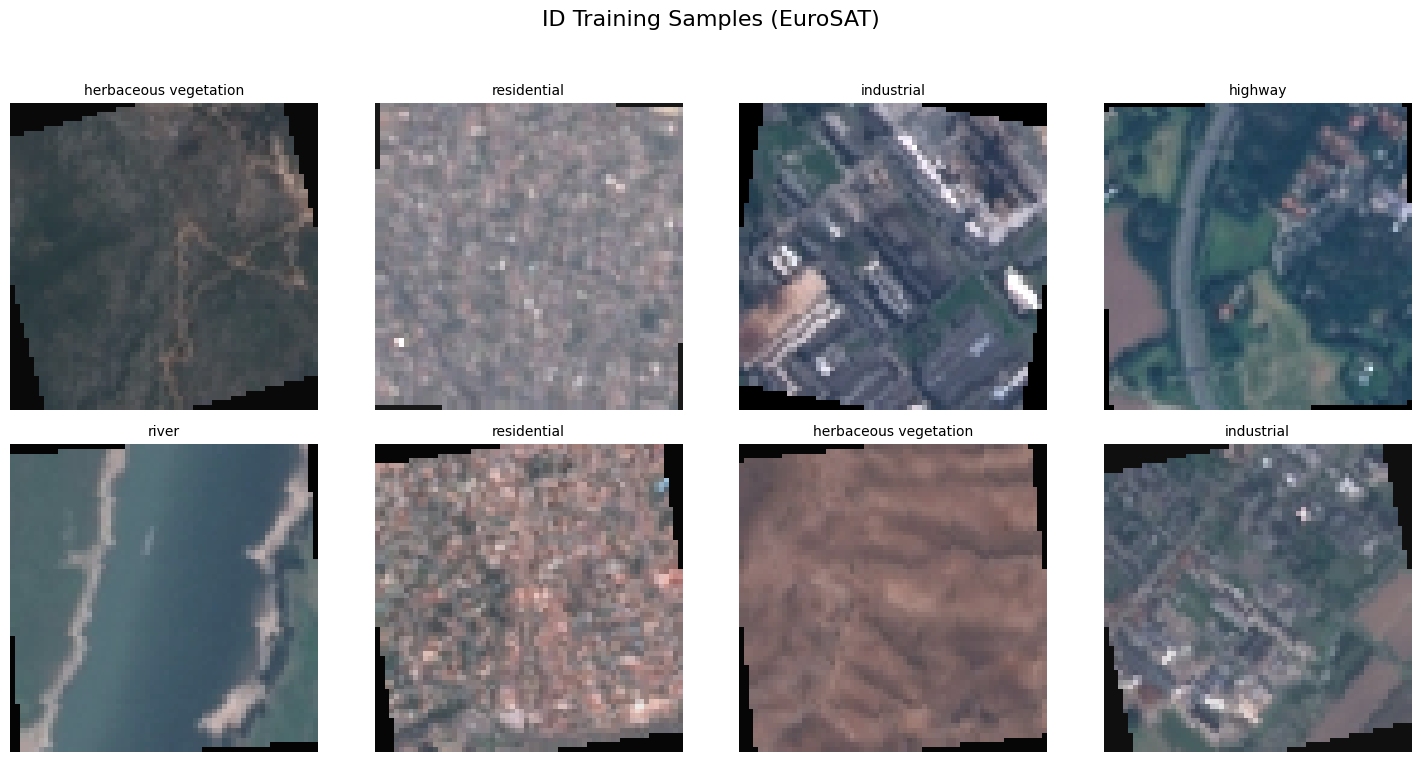

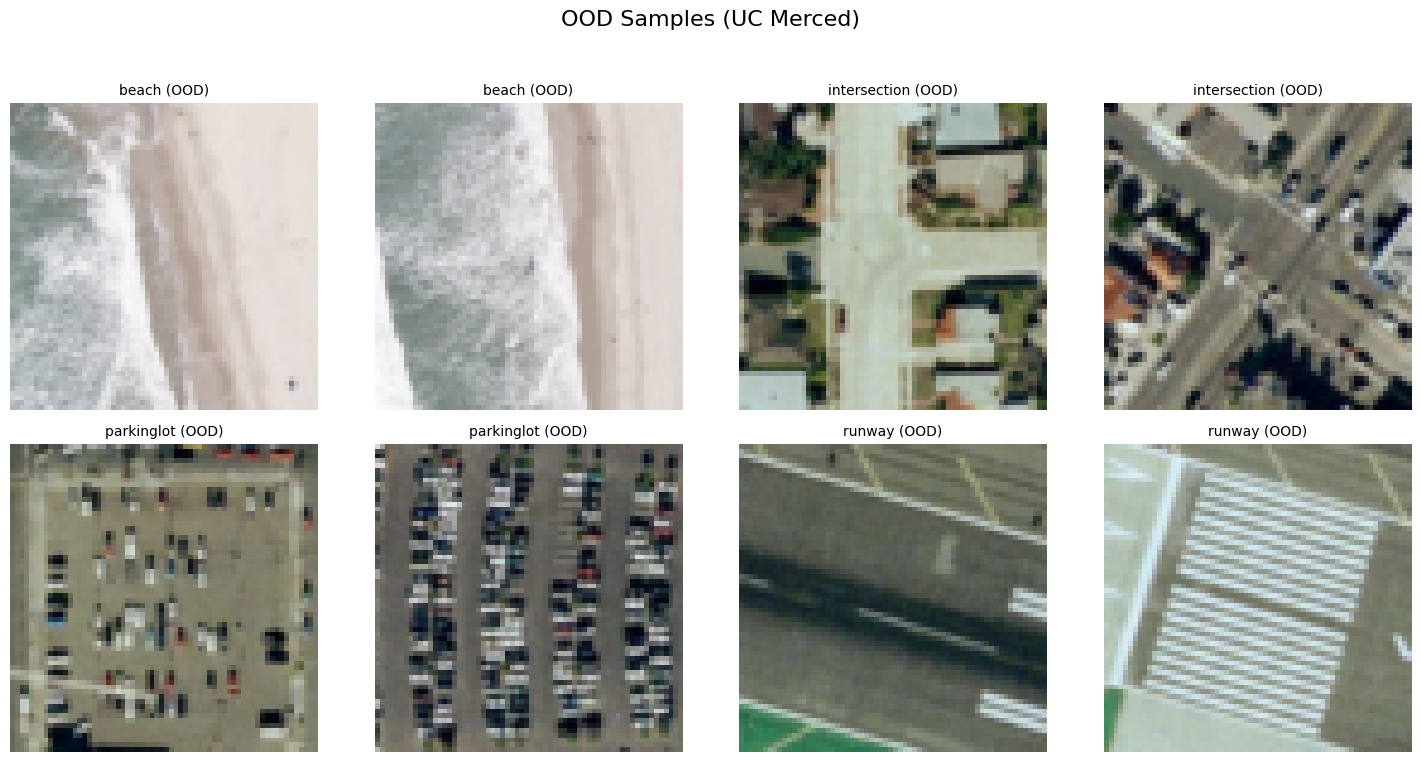

In [15]:
def denormalize(tensor):
    """Denormalize image tensor for visualization."""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

def visualize_samples_diverse(loader, title, class_names, num_samples=8, is_ood_loader=False, ood_label_to_name=None):
    """Visualize sample images from dataloader, ensuring diversity in OOD classes."""
    
    if is_ood_loader and ood_label_to_name is not None:
        # For OOD loader, collect samples from different classes
        collected_samples = {label: [] for label in ood_label_to_name.keys()}
        
        # Iterate through the loader to collect samples from each class
        for images, labels in loader:
            for img, lbl in zip(images, labels):
                label_idx = lbl.item()
                if label_idx in collected_samples and len(collected_samples[label_idx]) < 2:
                    collected_samples[label_idx].append((img, label_idx))
            
            # Check if we have enough samples
            if all(len(samples) >= 2 for samples in collected_samples.values()):
                break
        
        # Flatten collected samples
        all_samples = []
        for label_idx in sorted(collected_samples.keys()):
            all_samples.extend(collected_samples[label_idx][:2])
        
        # Limit to num_samples
        all_samples = all_samples[:num_samples]
        
        if len(all_samples) == 0:
            print(f"No data in {title} loader.")
            return
        
        fig, axes = plt.subplots(2, 4, figsize=(15, 8))
        fig.suptitle(title, fontsize=16)
        
        for i, ax in enumerate(axes.flat):
            if i >= len(all_samples):
                ax.axis('off')
                continue
            
            img, label_idx = all_samples[i]
            img = denormalize(img).numpy().transpose(1, 2, 0)
            img = np.clip(img, 0, 1)
            ax.imshow(img)
            
            if label_idx in ood_label_to_name:
                title_text = f"{ood_label_to_name[label_idx]} (OOD)"
            else:
                title_text = f"Unknown OOD (UC Merced Label: {label_idx})"
            
            ax.set_title(title_text, fontsize=10, ha='center')
            ax.axis('off')
        
        plt.tight_layout(pad=3.0)
        plt.show()
        
    else:
        # For ID loader, use original logic
        try:
            images, labels = next(iter(loader))
        except StopIteration:
            print(f"No data in {title} loader.")
            return

        fig, axes = plt.subplots(2, 4, figsize=(15, 8))
        fig.suptitle(title, fontsize=16)

        for i, ax in enumerate(axes.flat):
            if i >= len(images) or i >= num_samples:
                ax.axis('off')
                continue

            img = denormalize(images[i]).numpy().transpose(1, 2, 0)
            img = np.clip(img, 0, 1)
            ax.imshow(img)
            label_idx = labels[i].item()

            if label_idx >= 0 and label_idx < len(class_names):
                title_text = f"{class_names[label_idx]}"
            else:
                title_text = f"Label: {label_idx}"

            ax.set_title(title_text, fontsize=10, ha='center')
            ax.axis('off')

        plt.tight_layout(pad=3.0)
        plt.show()

# Create mapping from UC Merced original labels to OOD class names
ood_label_to_name_map = {ood_label_map[name]: name for name in OOD_CLASS_NAMES}

visualize_samples_diverse(train_loader, "ID Training Samples (EuroSAT)", ID_CLASS_NAMES)
visualize_samples_diverse(ood_loader, "OOD Samples (UC Merced)", OOD_CLASS_NAMES, 
                 is_ood_loader=True, ood_label_to_name=ood_label_to_name_map)

### 3.3. Supervised Fine-tuning with Pretrained Encoder

In [16]:
# Use the already-loaded pretrained encoder
# (Model was loaded in section 2.2 above - no need to load again)

print("="*80)
print("🎯 CREATING SUPERVISED MODEL WITH PROGRESSIVE UNFREEZING STRATEGY")
print("="*80)
print("Using encoder from already-loaded contrastive model")
print()

# Create supervised model with pretrained encoder
pretrained_encoder = contrastive_model.encoder
supervised_model = SupervisedModel(
    encoder=pretrained_encoder,
    num_classes=NUM_CLASSES,
    dropout_rate=DROPOUT_RATE
).to(device)

# Count parameters
total_params = sum(p.numel() for p in supervised_model.parameters())
encoder_params = sum(p.numel() for p in supervised_model.encoder.parameters())
classifier_params = sum(p.numel() for p in supervised_model.classifier.parameters())

print(f"✓ Supervised model created with pretrained encoder")
print(f"  Total parameters: {total_params:,}")
print(f"  Encoder (pretrained): {encoder_params:,}")
print(f"  Classifier (new): {classifier_params:,}")

# ==========================================
# PROGRESSIVE UNFREEZING + DISCRIMINATIVE LEARNING RATES (DiffLR)
# ==========================================
print("\n" + "="*80)
print("🌡️ PROGRESSIVE UNFREEZING + DISCRIMINATIVE LEARNING RATES (DiffLR)")
print("="*80)

# Initially freeze ALL encoder layers
for param in supervised_model.encoder.parameters():
    param.requires_grad = False

print("✓ Initial state: All encoder layers FROZEN")
print("  Only classifier will be trained in early epochs")
print("\n📊 Discriminative Learning Rate Strategy:")
print(f"  - Classifier (HEAD):  {HEAD_LR:.0e}  [HIGH - fast adaptation]")
print(f"  - Encoder (BACKBONE): {BACKBONE_LR:.0e}  [VERY LOW - preserve features]")
print(f"  - LR Ratio: {HEAD_LR/BACKBONE_LR:.0f}x (head learns {HEAD_LR/BACKBONE_LR:.0f}x faster)")
print("\n🌡️ Unfreezing schedule:")
print("  Phase 1 (Epochs 0-50):   Classifier only (encoder frozen)")
print("  Phase 2 (Epochs 51-100):  + Conv3 (top layer)")
print("  Phase 3 (Epochs 101-150): + Conv2 (middle layer)")
print("  Phase 4 (Epochs 151-200): + Conv1 (all layers, full fine-tuning)")
print("="*80)

🎯 CREATING SUPERVISED MODEL WITH PROGRESSIVE UNFREEZING STRATEGY
Using encoder from already-loaded contrastive model

✓ Supervised model created with pretrained encoder
  Total parameters: 1,412,682
  Encoder (pretrained): 1,147,200
  Classifier (new): 265,482

🌡️ PROGRESSIVE UNFREEZING + DISCRIMINATIVE LEARNING RATES (DiffLR)
✓ Initial state: All encoder layers FROZEN
  Only classifier will be trained in early epochs

📊 Discriminative Learning Rate Strategy:
  - Classifier (HEAD):  1e-03  [HIGH - fast adaptation]
  - Encoder (BACKBONE): 1e-04  [VERY LOW - preserve features]
  - LR Ratio: 10x (head learns 10x faster)

🌡️ Unfreezing schedule:
  Phase 1 (Epochs 0-50):   Classifier only (encoder frozen)
  Phase 2 (Epochs 51-100):  + Conv3 (top layer)
  Phase 3 (Epochs 101-150): + Conv2 (middle layer)
  Phase 4 (Epochs 151-200): + Conv1 (all layers, full fine-tuning)


In [17]:
# ==========================================
# Progressive Unfreezing Helper Functions
# ==========================================

def unfreeze_layer(model, layer_name):
    """Unfreeze a specific encoder layer."""
    if layer_name == 'conv3':
        for param in model.encoder.conv3.parameters():
            param.requires_grad = True
    elif layer_name == 'conv2':
        for param in model.encoder.conv2.parameters():
            param.requires_grad = True
    elif layer_name == 'conv1':
        for param in model.encoder.conv1.parameters():
            param.requires_grad = True
    print(f"  ✓ Unfroze {layer_name}")


def get_layer_params(model):
    """Get parameters grouped by layer for differential learning rates."""
    # Classifier (always trainable)
    classifier_params = list(model.classifier.parameters())
    
    # Encoder layers (conditionally trainable based on unfreezing)
    conv1_params = [p for p in model.encoder.conv1.parameters() if p.requires_grad]
    conv2_params = [p for p in model.encoder.conv2.parameters() if p.requires_grad]
    conv3_params = [p for p in model.encoder.conv3.parameters() if p.requires_grad]
    
    return {
        'classifier': classifier_params,
        'conv3': conv3_params,
        'conv2': conv2_params,
        'conv1': conv1_params
    }


def create_optimizer_with_differential_lr(model, head_lr, current_backbone_lr):
    """
    Create optimizer with DISCRIMINATIVE learning rates (DiffLR).
    
    Core Concept: Use HIGH LR for head, MODERATE LR for backbone.
    
    Learning rate strategy:
    - Classifier (head/new layers): head_lr (e.g., 1e-3) - HIGH
    - All Encoder layers (backbone/pretrained): current_backbone_lr (e.g., 1e-4) - MODERATE
    
    This allows:
    - Fast adaptation of new classification head
    - Better backbone adaptation while preserving pretrained features
    - Warmup support for stable training
    """
    layer_params = get_layer_params(model)
    
    param_groups = []
    
    # Classifier (HEAD) - HIGH learning rate for fast adaptation
    if layer_params['classifier']:
        param_groups.append({
            'params': layer_params['classifier'],
            'lr': head_lr,
            'name': 'classifier (HEAD)'
        })
    
    # All Encoder layers (BACKBONE) - MODERATE learning rate (with warmup support)
    # Combine all backbone layers with the same learning rate
    backbone_params = []
    backbone_layers = []
    
    if layer_params['conv3']:
        backbone_params.extend(layer_params['conv3'])
        backbone_layers.append('conv3')
    
    if layer_params['conv2']:
        backbone_params.extend(layer_params['conv2'])
        backbone_layers.append('conv2')
    
    if layer_params['conv1']:
        backbone_params.extend(layer_params['conv1'])
        backbone_layers.append('conv1')
    
    if backbone_params:
        param_groups.append({
            'params': backbone_params,
            'lr': current_backbone_lr,
            'name': f"backbone ({'+'.join(backbone_layers)})"
        })
    
    optimizer = optim.Adam(param_groups)
    return optimizer


def update_unfreezing_schedule(model, epoch, head_lr, backbone_lr,
                               warmup_epochs=10, warmup_start_lr=1e-5,
                               unfreeze_conv3_epoch=30, unfreeze_conv2_epoch=60, unfreeze_conv1_epoch=90):
    """
    Update model unfreezing based on epoch and recreate optimizer with DiffLR + Warmup.
    
    OPTIMIZED Progressive unfreezing schedule (EARLIER):
    - Epochs 0-29: Classifier only (encoder frozen) + WARMUP
    - Epochs 30-59: Classifier + Conv3
    - Epochs 60-89: Classifier + Conv3 + Conv2
    - Epochs 90+: Full model (all layers)
    
    Warmup Schedule:
    - First 10 epochs: Backbone LR gradually increases from 1e-5 to target 1e-4
    
    Discriminative Learning Rates:
    - Head (classifier): head_lr (high, e.g., 1e-3)
    - Backbone (encoder): backbone_lr (moderate, e.g., 1e-4) with warmup
    """
    unfroze_new_layer = False
    
    # Calculate current backbone LR (with warmup support)
    if epoch < warmup_epochs:
        current_backbone_lr = warmup_start_lr + (backbone_lr - warmup_start_lr) * (epoch / warmup_epochs)
    else:
        current_backbone_lr = backbone_lr
    
    if epoch == unfreeze_conv3_epoch:
        print(f"\n{'='*80}")
        print(f"📍 EPOCH {epoch}: PHASE 2 - Unfreezing Conv3 (top layer)")
        print(f"{'='*80}")
        unfreeze_layer(model, 'conv3')
        unfroze_new_layer = True
    
    elif epoch == unfreeze_conv2_epoch:
        print(f"\n{'='*80}")
        print(f"📍 EPOCH {epoch}: PHASE 3 - Unfreezing Conv2 (middle layer)")
        print(f"{'='*80}")
        unfreeze_layer(model, 'conv2')
        unfroze_new_layer = True
    
    elif epoch == unfreeze_conv1_epoch:
        print(f"\n{'='*80}")
        print(f"📍 EPOCH {epoch}: PHASE 4 - Unfreezing Conv1 (all layers)")
        print(f"{'='*80}")
        unfreeze_layer(model, 'conv1')
        unfroze_new_layer = True
    
    # Recreate optimizer with discriminative learning rates
    if unfroze_new_layer or epoch == 0:
        optimizer = create_optimizer_with_differential_lr(model, head_lr, current_backbone_lr)
        
        # Print current learning rates with DiffLR info
        print("\n  📊 Discriminative Learning Rates (DiffLR):")
        if epoch < warmup_epochs:
            print(f"  🔥 WARMUP Phase: Epoch {epoch}/{warmup_epochs} - Backbone LR: {current_backbone_lr:.2e} (warming up to {backbone_lr:.2e})")
        for i, param_group in enumerate(optimizer.param_groups):
            layer_name = param_group.get('name', f'group_{i}')
            lr_value = param_group['lr']
            lr_type = 'HIGH (Head)' if 'HEAD' in layer_name else 'MODERATE (Backbone)'
            print(f"    {layer_name:25s}: {lr_value:.0e}  [{lr_type}]")
        if len(optimizer.param_groups) > 1:
            ratio = optimizer.param_groups[0]['lr'] / optimizer.param_groups[1]['lr']
            print(f"\n    💡 Head/Backbone LR Ratio: {ratio:.0f}x")
        print(f"{'='*80}\n")
        
        return optimizer, True
    
    return None, False


print("✓ Progressive unfreezing helper functions defined (OPTIMIZED)")
print("  - unfreeze_layer(): Unfreeze specific encoder layers")
print("  - get_layer_params(): Group parameters by layer")
print("  - create_optimizer_with_differential_lr(): Create optimizer with DiffLR")
print("  - update_unfreezing_schedule(): Manage EARLIER unfreezing (30/60/90) + WARMUP + DiffLR")

✓ Progressive unfreezing helper functions defined (OPTIMIZED)
  - unfreeze_layer(): Unfreeze specific encoder layers
  - get_layer_params(): Group parameters by layer
  - create_optimizer_with_differential_lr(): Create optimizer with DiffLR
  - update_unfreezing_schedule(): Manage EARLIER unfreezing (30/60/90) + WARMUP + DiffLR


In [18]:
# Display trainable parameters summary for each phase
print("\n" + "="*80)
print("📊 TRAINABLE PARAMETERS SUMMARY BY PHASE")
print("="*80)

def count_trainable_params(model):
    """Count trainable parameters in the model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_layer_params(layer):
    """Count parameters in a specific layer."""
    return sum(p.numel() for p in layer.parameters())

# Total parameters
total = count_layer_params(supervised_model)
conv1_params = count_layer_params(supervised_model.encoder.conv1)
conv2_params = count_layer_params(supervised_model.encoder.conv2)
conv3_params = count_layer_params(supervised_model.encoder.conv3)
classifier_params = count_layer_params(supervised_model.classifier)

print(f"\nTotal Model Parameters: {total:,}")
print(f"  Conv1 (bottom): {conv1_params:,}")
print(f"  Conv2 (middle): {conv2_params:,}")
print(f"  Conv3 (top):    {conv3_params:,}")
print(f"  Classifier:     {classifier_params:,}")

# Trainable parameters by phase
print(f"\n{'Phase':<20} {'Trainable Params':<20} {'% of Total':<15} {'Trainable Layers'}")
print("-" * 80)

phase_info = [
    ("Phase 1 (0-50)", classifier_params, "Classifier"),
    ("Phase 2 (51-100)", classifier_params + conv3_params, "Classifier + Conv3"),
    ("Phase 3 (101-150)", classifier_params + conv3_params + conv2_params, "Classifier + Conv3 + Conv2"),
    ("Phase 4 (151-200)", total, "All layers")
]

for phase_name, trainable, layers in phase_info:
    percentage = (trainable / total) * 100
    print(f"{phase_name:<20} {trainable:>15,}   {percentage:>6.2f}%        {layers}")

print("="*80)


📊 TRAINABLE PARAMETERS SUMMARY BY PHASE

Total Model Parameters: 1,412,682
  Conv1 (bottom): 38,976
  Conv2 (middle): 221,952
  Conv3 (top):    886,272
  Classifier:     265,482

Phase                Trainable Params     % of Total      Trainable Layers
--------------------------------------------------------------------------------
Phase 1 (0-50)               265,482    18.79%        Classifier
Phase 2 (51-100)           1,151,754    81.53%        Classifier + Conv3
Phase 3 (101-150)          1,373,706    97.24%        Classifier + Conv3 + Conv2
Phase 4 (151-200)          1,412,682   100.00%        All layers


### 📊 Discriminative Learning Rates (DiffLR) Visualization

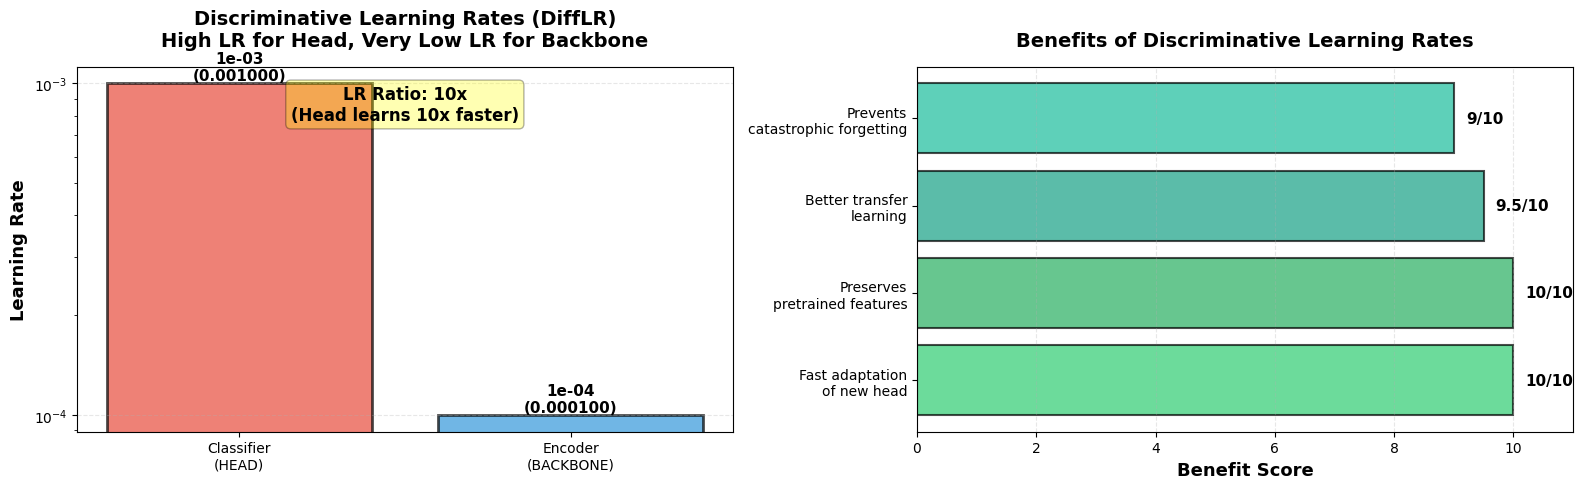

📊 DISCRIMINATIVE LEARNING RATES (DiffLR) - KEY CONCEPT

✓ Head Learning Rate:     1e-03  (HIGH)
✓ Backbone Learning Rate: 1e-04  (VERY LOW)
✓ Ratio:                  10x difference

💡 Why This Works:
  1. New classifier head needs fast adaptation to new task
  2. Pretrained backbone has valuable features - don't destroy them!
  3. Very low backbone LR allows gentle fine-tuning without catastrophic forgetting
  4. High head LR enables rapid convergence on new task


In [19]:
# Visualize Discriminative Learning Rates concept
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Left plot: Learning Rate Comparison
components = ['Classifier\n(HEAD)', 'Encoder\n(BACKBONE)']
lr_values = [HEAD_LR, BACKBONE_LR]
colors = ['#e74c3c', '#3498db']  # Red for high, blue for low

bars = ax1.bar(components, lr_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_ylabel('Learning Rate', fontsize=13, fontweight='bold')
ax1.set_title('Discriminative Learning Rates (DiffLR)\nHigh LR for Head, Very Low LR for Backbone', 
              fontsize=14, fontweight='bold', pad=15)
ax1.set_yscale('log')
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bar, value in zip(bars, lr_values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:.0e}\n({value:.6f})',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add ratio annotation
ratio = HEAD_LR / BACKBONE_LR
ax1.text(0.5, 0.95, f'LR Ratio: {ratio:.0f}x\n(Head learns {ratio:.0f}x faster)', 
         transform=ax1.transAxes, fontsize=12, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3),
         ha='center', va='top')

# Right plot: DiffLR Benefits
benefits = [
    'Fast adaptation\nof new head',
    'Preserves\npretrained features',
    'Better transfer\nlearning',
    'Prevents\ncatastrophic forgetting'
]
benefit_scores = [10, 10, 9.5, 9]
colors_benefits = ['#2ecc71', '#27ae60', '#16a085', '#1abc9c']

bars2 = ax2.barh(benefits, benefit_scores, color=colors_benefits, alpha=0.7, 
                  edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Benefit Score', fontsize=13, fontweight='bold')
ax2.set_title('Benefits of Discriminative Learning Rates', 
              fontsize=14, fontweight='bold', pad=15)
ax2.set_xlim([0, 11])
ax2.grid(axis='x', alpha=0.3, linestyle='--')

# Add score labels
for bar, score in zip(bars2, benefit_scores):
    width = bar.get_width()
    ax2.text(width + 0.2, bar.get_y() + bar.get_height()/2.,
             f'{score}/10',
             ha='left', va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("="*80)
print("📊 DISCRIMINATIVE LEARNING RATES (DiffLR) - KEY CONCEPT")
print("="*80)
print(f"\n✓ Head Learning Rate:     {HEAD_LR:.0e}  (HIGH)")
print(f"✓ Backbone Learning Rate: {BACKBONE_LR:.0e}  (VERY LOW)")
print(f"✓ Ratio:                  {HEAD_LR/BACKBONE_LR:.0f}x difference")
print("\n💡 Why This Works:")
print("  1. New classifier head needs fast adaptation to new task")
print("  2. Pretrained backbone has valuable features - don't destroy them!")
print("  3. Very low backbone LR allows gentle fine-tuning without catastrophic forgetting")
print("  4. High head LR enables rapid convergence on new task")
print("="*80)

In [20]:
# Supervised training functions
def train_epoch(model, loader, criterion, optimizer, device, scaler=None):
    """Train for one epoch with supervised learning. Uses mixed precision."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        
        # Mixed precision training
        if scaler is not None:
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({'loss': loss.item(), 'acc': 100. * correct / total})

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    """Validate the model."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validation'):
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            
            # Use mixed precision for validation too
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Supervised learning setup
criterion = nn.CrossEntropyLoss()

# Calculate initial backbone LR with warmup
initial_backbone_lr = BACKBONE_WARMUP_START_LR

# Create initial optimizer with DISCRIMINATIVE LEARNING RATES (DiffLR) + WARMUP
# (initially only classifier is trainable)
optimizer = create_optimizer_with_differential_lr(supervised_model, HEAD_LR, initial_backbone_lr)

# Scheduler will be applied to all parameter groups
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Initialize mixed precision scaler for supervised training
supervised_scaler = torch.amp.GradScaler() if device.type == 'cuda' else None

print("✓ Supervised training setup complete")
print(f"  Loss: CrossEntropy")
print(f"  Optimizer: Adam with Discriminative Learning Rates (DiffLR) + WARMUP")
print(f"  Head LR: {HEAD_LR:.0e} (high)")
print(f"  Backbone LR: {BACKBONE_LR:.0e} (moderate) with warmup from {BACKBONE_WARMUP_START_LR:.0e}")
print(f"  LR Ratio: {HEAD_LR/BACKBONE_LR:.0f}x (after warmup)")
print(f"  Warmup: {WARMUP_EPOCHS} epochs")
print(f"  Scheduler: ReduceLROnPlateau")
if supervised_scaler is not None:
    print(f"  Mixed precision: ENABLED (faster training, lower memory)")

print("\n📊 Initial Discriminative Learning Rates (with Warmup):")
for i, param_group in enumerate(optimizer.param_groups):
    layer_name = param_group.get('name', f'group_{i}')
    lr_type = 'HIGH (Head)' if 'HEAD' in layer_name else 'MODERATE (Backbone - Warmup)'
    print(f"  {layer_name:25s}: {param_group['lr']:.0e}  [{lr_type}]")

✓ Supervised training setup complete
  Loss: CrossEntropy
  Optimizer: Adam with Discriminative Learning Rates (DiffLR) + WARMUP
  Head LR: 1e-03 (high)
  Backbone LR: 1e-04 (moderate) with warmup from 1e-05
  LR Ratio: 10x (after warmup)
  Warmup: 10 epochs
  Scheduler: ReduceLROnPlateau
  Mixed precision: ENABLED (faster training, lower memory)

📊 Initial Discriminative Learning Rates (with Warmup):
  classifier (HEAD)        : 1e-03  [HIGH (Head)]


In [21]:
# Supervised fine-tuning loop with PROGRESSIVE UNFREEZING + DiffLR + WARMUP
print("\n" + "="*80)
print("STAGE 2: SUPERVISED FINE-TUNING WITH OPTIMIZATIONS")
print("="*80)
print(f"Training for {NUM_EPOCHS} epochs with labeled data...")
print(f"ID classes: {NUM_CLASSES} classes from RESISC45")
print(f"💡 Using Discriminative Learning Rates: Head={HEAD_LR:.0e}, Backbone={BACKBONE_LR:.0e}")
print(f"🔥 Warmup: {WARMUP_EPOCHS} epochs ({BACKBONE_WARMUP_START_LR:.0e} → {BACKBONE_LR:.0e})")
print(f"🌡️ Progressive Unfreezing: Conv3@{UNFREEZE_CONV3_EPOCH}, Conv2@{UNFREEZE_CONV2_EPOCH}, Conv1@{UNFREEZE_CONV1_EPOCH}")
print(f"🎨 Aggressive augmentation enabled")
print()

train_losses = []
train_accs = []
val_losses = []
val_accs = []
best_val_acc = 0.0

for epoch in range(NUM_EPOCHS):
    # ==========================================
    # Progressive Unfreezing Update with DiffLR + Warmup
    # ==========================================
    new_optimizer, optimizer_updated = update_unfreezing_schedule(
        supervised_model, epoch, HEAD_LR, BACKBONE_LR,
        warmup_epochs=WARMUP_EPOCHS,
        warmup_start_lr=BACKBONE_WARMUP_START_LR,
        unfreeze_conv3_epoch=UNFREEZE_CONV3_EPOCH,
        unfreeze_conv2_epoch=UNFREEZE_CONV2_EPOCH,
        unfreeze_conv1_epoch=UNFREEZE_CONV1_EPOCH
    )
    
    if optimizer_updated:
        optimizer = new_optimizer
        # Recreate scheduler for new optimizer
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    # ==========================================
    # Training & Validation
    # ==========================================
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"{'='*60}")

    train_loss, train_acc = train_epoch(
        supervised_model, train_loader, criterion, optimizer, device, scaler=supervised_scaler
    )
    val_loss, val_acc = validate(supervised_model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    scheduler.step(val_loss)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': supervised_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }, 'best_supervised_model.pth')
        print(f"✓ Saved best model with validation accuracy: {val_acc:.2f}%")

print(f"\n{'='*60}")
print(f"SUPERVISED FINE-TUNING COMPLETE!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"{'='*60}")
print("\nOPTIMIZED Progressive unfreezing strategy applied:")
print(f"  Phase 1 (0-{UNFREEZE_CONV3_EPOCH-1}):     Classifier only + Warmup ({WARMUP_EPOCHS} epochs)")
print(f"  Phase 2 ({UNFREEZE_CONV3_EPOCH}-{UNFREEZE_CONV2_EPOCH-1}):   Classifier + Conv3")
print(f"  Phase 3 ({UNFREEZE_CONV2_EPOCH}-{UNFREEZE_CONV1_EPOCH-1}):  Classifier + Conv3 + Conv2")
print(f"  Phase 4 ({UNFREEZE_CONV1_EPOCH}-{NUM_EPOCHS}):  Full model (all layers)")
print(f"{'='*60}")


STAGE 2: SUPERVISED FINE-TUNING WITH OPTIMIZATIONS
Training for 200 epochs with labeled data...
ID classes: 10 classes from RESISC45
💡 Using Discriminative Learning Rates: Head=1e-03, Backbone=1e-04
🔥 Warmup: 10 epochs (1e-05 → 1e-04)
🌡️ Progressive Unfreezing: Conv3@30, Conv2@60, Conv1@90
🎨 Aggressive augmentation enabled


  📊 Discriminative Learning Rates (DiffLR):
  🔥 WARMUP Phase: Epoch 0/10 - Backbone LR: 1.00e-05 (warming up to 1.00e-04)
    classifier (HEAD)        : 1e-03  [HIGH (Head)]


Epoch 1/200


Training:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_16684/935374249.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation:   0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_16684/935374249.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 6/6 [00:01<00:00,  4.84it/s]



Train Loss: 2.1624 | Train Acc: 32.34%
Val Loss: 1.8118 | Val Acc: 40.41%
✓ Saved best model with validation accuracy: 40.41%

Epoch 2/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.24it/s]



Train Loss: 1.4701 | Train Acc: 51.73%
Val Loss: 1.1293 | Val Acc: 60.67%
✓ Saved best model with validation accuracy: 60.67%

Epoch 3/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]



Train Loss: 1.0737 | Train Acc: 61.20%
Val Loss: 0.9263 | Val Acc: 66.63%
✓ Saved best model with validation accuracy: 66.63%

Epoch 4/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  4.84it/s]



Train Loss: 0.9553 | Train Acc: 65.01%
Val Loss: 0.8507 | Val Acc: 69.11%
✓ Saved best model with validation accuracy: 69.11%

Epoch 5/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]



Train Loss: 0.8921 | Train Acc: 67.94%
Val Loss: 0.7970 | Val Acc: 70.59%
✓ Saved best model with validation accuracy: 70.59%

Epoch 6/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.31it/s]



Train Loss: 0.8480 | Train Acc: 69.31%
Val Loss: 0.7555 | Val Acc: 72.72%
✓ Saved best model with validation accuracy: 72.72%

Epoch 7/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.31it/s]



Train Loss: 0.8213 | Train Acc: 70.51%
Val Loss: 0.7110 | Val Acc: 74.44%
✓ Saved best model with validation accuracy: 74.44%

Epoch 8/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.36it/s]



Train Loss: 0.7934 | Train Acc: 71.69%
Val Loss: 0.6917 | Val Acc: 75.06%
✓ Saved best model with validation accuracy: 75.06%

Epoch 9/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.33it/s]



Train Loss: 0.7778 | Train Acc: 71.85%
Val Loss: 0.6752 | Val Acc: 75.37%
✓ Saved best model with validation accuracy: 75.37%

Epoch 10/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]



Train Loss: 0.7610 | Train Acc: 72.36%
Val Loss: 0.6571 | Val Acc: 76.50%
✓ Saved best model with validation accuracy: 76.50%

Epoch 11/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.32it/s]



Train Loss: 0.7415 | Train Acc: 73.15%
Val Loss: 0.6452 | Val Acc: 76.98%
✓ Saved best model with validation accuracy: 76.98%

Epoch 12/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.22it/s]



Train Loss: 0.7309 | Train Acc: 73.69%
Val Loss: 0.6368 | Val Acc: 77.28%
✓ Saved best model with validation accuracy: 77.28%

Epoch 13/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]



Train Loss: 0.7185 | Train Acc: 74.26%
Val Loss: 0.6252 | Val Acc: 77.69%
✓ Saved best model with validation accuracy: 77.69%

Epoch 14/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.31it/s]



Train Loss: 0.7142 | Train Acc: 74.43%
Val Loss: 0.6073 | Val Acc: 78.15%
✓ Saved best model with validation accuracy: 78.15%

Epoch 15/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]



Train Loss: 0.7041 | Train Acc: 74.80%
Val Loss: 0.6012 | Val Acc: 78.61%
✓ Saved best model with validation accuracy: 78.61%

Epoch 16/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]



Train Loss: 0.7017 | Train Acc: 74.46%
Val Loss: 0.6101 | Val Acc: 77.89%

Epoch 17/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]



Train Loss: 0.6995 | Train Acc: 74.59%
Val Loss: 0.6057 | Val Acc: 78.76%
✓ Saved best model with validation accuracy: 78.76%

Epoch 18/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]



Train Loss: 0.6815 | Train Acc: 75.56%
Val Loss: 0.5806 | Val Acc: 79.57%
✓ Saved best model with validation accuracy: 79.57%

Epoch 19/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]



Train Loss: 0.6762 | Train Acc: 75.56%
Val Loss: 0.5750 | Val Acc: 79.43%

Epoch 20/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]



Train Loss: 0.6771 | Train Acc: 75.44%
Val Loss: 0.5960 | Val Acc: 78.50%

Epoch 21/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.25it/s]



Train Loss: 0.6718 | Train Acc: 75.81%
Val Loss: 0.5672 | Val Acc: 79.26%

Epoch 22/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]



Train Loss: 0.6575 | Train Acc: 76.66%
Val Loss: 0.5736 | Val Acc: 79.31%

Epoch 23/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.31it/s]



Train Loss: 0.6578 | Train Acc: 76.41%
Val Loss: 0.5543 | Val Acc: 80.06%
✓ Saved best model with validation accuracy: 80.06%

Epoch 24/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.33it/s]



Train Loss: 0.6528 | Train Acc: 76.53%
Val Loss: 0.5668 | Val Acc: 79.59%

Epoch 25/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.39it/s]



Train Loss: 0.6556 | Train Acc: 76.36%
Val Loss: 0.5541 | Val Acc: 80.19%
✓ Saved best model with validation accuracy: 80.19%

Epoch 26/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]



Train Loss: 0.6546 | Train Acc: 76.36%
Val Loss: 0.5504 | Val Acc: 79.91%

Epoch 27/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.37it/s]



Train Loss: 0.6478 | Train Acc: 76.84%
Val Loss: 0.5431 | Val Acc: 80.46%
✓ Saved best model with validation accuracy: 80.46%

Epoch 28/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.31it/s]



Train Loss: 0.6412 | Train Acc: 77.16%
Val Loss: 0.5478 | Val Acc: 80.48%
✓ Saved best model with validation accuracy: 80.48%

Epoch 29/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.25it/s]



Train Loss: 0.6359 | Train Acc: 77.08%
Val Loss: 0.5391 | Val Acc: 80.35%

Epoch 30/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]



Train Loss: 0.6372 | Train Acc: 76.93%
Val Loss: 0.5516 | Val Acc: 80.13%

📍 EPOCH 30: PHASE 2 - Unfreezing Conv3 (top layer)
  ✓ Unfroze conv3

  📊 Discriminative Learning Rates (DiffLR):
    classifier (HEAD)        : 1e-03  [HIGH (Head)]
    backbone (conv3)         : 1e-04  [MODERATE (Backbone)]

    💡 Head/Backbone LR Ratio: 10x


Epoch 31/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.36it/s]



Train Loss: 0.6396 | Train Acc: 76.89%
Val Loss: 0.5452 | Val Acc: 80.11%

Epoch 32/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]



Train Loss: 0.6165 | Train Acc: 77.78%
Val Loss: 0.5207 | Val Acc: 81.11%
✓ Saved best model with validation accuracy: 81.11%

Epoch 33/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.24it/s]



Train Loss: 0.6163 | Train Acc: 77.98%
Val Loss: 0.5125 | Val Acc: 81.70%
✓ Saved best model with validation accuracy: 81.70%

Epoch 34/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]



Train Loss: 0.6102 | Train Acc: 77.98%
Val Loss: 0.4997 | Val Acc: 82.20%
✓ Saved best model with validation accuracy: 82.20%

Epoch 35/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]



Train Loss: 0.5973 | Train Acc: 78.56%
Val Loss: 0.5206 | Val Acc: 81.26%

Epoch 36/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]



Train Loss: 0.5936 | Train Acc: 78.72%
Val Loss: 0.4949 | Val Acc: 82.44%
✓ Saved best model with validation accuracy: 82.44%

Epoch 37/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.21it/s]



Train Loss: 0.5881 | Train Acc: 78.64%
Val Loss: 0.4885 | Val Acc: 82.46%
✓ Saved best model with validation accuracy: 82.46%

Epoch 38/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.33it/s]



Train Loss: 0.5776 | Train Acc: 79.03%
Val Loss: 0.4855 | Val Acc: 82.67%
✓ Saved best model with validation accuracy: 82.67%

Epoch 39/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]



Train Loss: 0.5673 | Train Acc: 79.63%
Val Loss: 0.4771 | Val Acc: 82.74%
✓ Saved best model with validation accuracy: 82.74%

Epoch 40/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.31it/s]



Train Loss: 0.5642 | Train Acc: 79.93%
Val Loss: 0.4722 | Val Acc: 83.39%
✓ Saved best model with validation accuracy: 83.39%

Epoch 41/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]



Train Loss: 0.5648 | Train Acc: 79.80%
Val Loss: 0.4686 | Val Acc: 83.20%

Epoch 42/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]



Train Loss: 0.5542 | Train Acc: 80.15%
Val Loss: 0.4638 | Val Acc: 83.33%

Epoch 43/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]



Train Loss: 0.5536 | Train Acc: 80.09%
Val Loss: 0.4640 | Val Acc: 83.11%

Epoch 44/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.32it/s]



Train Loss: 0.5470 | Train Acc: 80.11%
Val Loss: 0.4638 | Val Acc: 83.43%
✓ Saved best model with validation accuracy: 83.43%

Epoch 45/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.34it/s]



Train Loss: 0.5443 | Train Acc: 80.47%
Val Loss: 0.4506 | Val Acc: 83.93%
✓ Saved best model with validation accuracy: 83.93%

Epoch 46/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]



Train Loss: 0.5452 | Train Acc: 80.38%
Val Loss: 0.4500 | Val Acc: 83.93%

Epoch 47/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.35it/s]



Train Loss: 0.5347 | Train Acc: 80.79%
Val Loss: 0.4412 | Val Acc: 84.35%
✓ Saved best model with validation accuracy: 84.35%

Epoch 48/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.39it/s]



Train Loss: 0.5333 | Train Acc: 81.04%
Val Loss: 0.4421 | Val Acc: 84.22%

Epoch 49/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]



Train Loss: 0.5284 | Train Acc: 81.22%
Val Loss: 0.4447 | Val Acc: 84.31%

Epoch 50/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]



Train Loss: 0.5219 | Train Acc: 81.15%
Val Loss: 0.4414 | Val Acc: 84.33%

Epoch 51/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.33it/s]



Train Loss: 0.5203 | Train Acc: 81.64%
Val Loss: 0.4389 | Val Acc: 84.39%
✓ Saved best model with validation accuracy: 84.39%

Epoch 52/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]



Train Loss: 0.5151 | Train Acc: 81.26%
Val Loss: 0.4360 | Val Acc: 84.48%
✓ Saved best model with validation accuracy: 84.48%

Epoch 53/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.32it/s]



Train Loss: 0.5194 | Train Acc: 81.44%
Val Loss: 0.4276 | Val Acc: 85.17%
✓ Saved best model with validation accuracy: 85.17%

Epoch 54/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.33it/s]



Train Loss: 0.5164 | Train Acc: 81.48%
Val Loss: 0.4299 | Val Acc: 85.17%

Epoch 55/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]



Train Loss: 0.5013 | Train Acc: 81.99%
Val Loss: 0.4217 | Val Acc: 85.04%

Epoch 56/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.36it/s]



Train Loss: 0.5064 | Train Acc: 81.80%
Val Loss: 0.4249 | Val Acc: 85.09%

Epoch 57/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.27it/s]



Train Loss: 0.5071 | Train Acc: 81.64%
Val Loss: 0.4260 | Val Acc: 84.59%

Epoch 58/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.25it/s]



Train Loss: 0.4977 | Train Acc: 82.12%
Val Loss: 0.4261 | Val Acc: 85.06%

Epoch 59/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.32it/s]



Train Loss: 0.4979 | Train Acc: 81.86%
Val Loss: 0.4137 | Val Acc: 85.13%

Epoch 60/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.31it/s]



Train Loss: 0.4958 | Train Acc: 82.35%
Val Loss: 0.4241 | Val Acc: 84.91%

📍 EPOCH 60: PHASE 3 - Unfreezing Conv2 (middle layer)
  ✓ Unfroze conv2

  📊 Discriminative Learning Rates (DiffLR):
    classifier (HEAD)        : 1e-03  [HIGH (Head)]
    backbone (conv3+conv2)   : 1e-04  [MODERATE (Backbone)]

    💡 Head/Backbone LR Ratio: 10x


Epoch 61/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.36it/s]



Train Loss: 0.4912 | Train Acc: 82.22%
Val Loss: 0.4227 | Val Acc: 85.19%
✓ Saved best model with validation accuracy: 85.19%

Epoch 62/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.19it/s]



Train Loss: 0.4833 | Train Acc: 82.75%
Val Loss: 0.4057 | Val Acc: 86.06%
✓ Saved best model with validation accuracy: 86.06%

Epoch 63/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]



Train Loss: 0.4812 | Train Acc: 83.04%
Val Loss: 0.3943 | Val Acc: 86.04%

Epoch 64/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.31it/s]



Train Loss: 0.4688 | Train Acc: 83.25%
Val Loss: 0.3966 | Val Acc: 86.06%

Epoch 65/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]



Train Loss: 0.4578 | Train Acc: 83.79%
Val Loss: 0.3902 | Val Acc: 86.35%
✓ Saved best model with validation accuracy: 86.35%

Epoch 66/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.31it/s]



Train Loss: 0.4541 | Train Acc: 83.64%
Val Loss: 0.3829 | Val Acc: 86.61%
✓ Saved best model with validation accuracy: 86.61%

Epoch 67/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]



Train Loss: 0.4577 | Train Acc: 83.54%
Val Loss: 0.3767 | Val Acc: 86.54%

Epoch 68/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.36it/s]



Train Loss: 0.4509 | Train Acc: 83.83%
Val Loss: 0.3753 | Val Acc: 86.76%
✓ Saved best model with validation accuracy: 86.76%

Epoch 69/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]



Train Loss: 0.4445 | Train Acc: 84.04%
Val Loss: 0.3698 | Val Acc: 87.11%
✓ Saved best model with validation accuracy: 87.11%

Epoch 70/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]



Train Loss: 0.4464 | Train Acc: 83.97%
Val Loss: 0.3674 | Val Acc: 87.24%
✓ Saved best model with validation accuracy: 87.24%

Epoch 71/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.32it/s]



Train Loss: 0.4307 | Train Acc: 84.44%
Val Loss: 0.3619 | Val Acc: 87.20%

Epoch 72/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.33it/s]



Train Loss: 0.4314 | Train Acc: 84.67%
Val Loss: 0.3617 | Val Acc: 87.48%
✓ Saved best model with validation accuracy: 87.48%

Epoch 73/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]



Train Loss: 0.4262 | Train Acc: 84.51%
Val Loss: 0.3537 | Val Acc: 87.20%

Epoch 74/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.36it/s]



Train Loss: 0.4264 | Train Acc: 84.79%
Val Loss: 0.3576 | Val Acc: 87.54%
✓ Saved best model with validation accuracy: 87.54%

Epoch 75/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.27it/s]



Train Loss: 0.4223 | Train Acc: 84.68%
Val Loss: 0.3568 | Val Acc: 87.52%

Epoch 76/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.31it/s]



Train Loss: 0.4178 | Train Acc: 84.89%
Val Loss: 0.3513 | Val Acc: 87.67%
✓ Saved best model with validation accuracy: 87.67%

Epoch 77/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.31it/s]



Train Loss: 0.4139 | Train Acc: 85.08%
Val Loss: 0.3452 | Val Acc: 87.76%
✓ Saved best model with validation accuracy: 87.76%

Epoch 78/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]



Train Loss: 0.4065 | Train Acc: 85.43%
Val Loss: 0.3543 | Val Acc: 87.80%
✓ Saved best model with validation accuracy: 87.80%

Epoch 79/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.27it/s]



Train Loss: 0.4099 | Train Acc: 85.56%
Val Loss: 0.3449 | Val Acc: 87.81%
✓ Saved best model with validation accuracy: 87.81%

Epoch 80/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]



Train Loss: 0.3960 | Train Acc: 85.82%
Val Loss: 0.3385 | Val Acc: 87.87%
✓ Saved best model with validation accuracy: 87.87%

Epoch 81/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.31it/s]



Train Loss: 0.4011 | Train Acc: 85.52%
Val Loss: 0.3371 | Val Acc: 88.30%
✓ Saved best model with validation accuracy: 88.30%

Epoch 82/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.18it/s]



Train Loss: 0.3972 | Train Acc: 85.82%
Val Loss: 0.3369 | Val Acc: 88.30%

Epoch 83/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]



Train Loss: 0.3937 | Train Acc: 86.10%
Val Loss: 0.3296 | Val Acc: 88.52%
✓ Saved best model with validation accuracy: 88.52%

Epoch 84/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.34it/s]



Train Loss: 0.3839 | Train Acc: 86.38%
Val Loss: 0.3296 | Val Acc: 88.56%
✓ Saved best model with validation accuracy: 88.56%

Epoch 85/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.31it/s]



Train Loss: 0.3854 | Train Acc: 86.23%
Val Loss: 0.3250 | Val Acc: 88.78%
✓ Saved best model with validation accuracy: 88.78%

Epoch 86/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]



Train Loss: 0.3840 | Train Acc: 86.30%
Val Loss: 0.3257 | Val Acc: 88.46%

Epoch 87/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]



Train Loss: 0.3810 | Train Acc: 86.10%
Val Loss: 0.3216 | Val Acc: 88.65%

Epoch 88/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.32it/s]



Train Loss: 0.3816 | Train Acc: 86.51%
Val Loss: 0.3215 | Val Acc: 88.69%

Epoch 89/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.24it/s]



Train Loss: 0.3795 | Train Acc: 86.29%
Val Loss: 0.3159 | Val Acc: 89.07%
✓ Saved best model with validation accuracy: 89.07%

Epoch 90/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.35it/s]



Train Loss: 0.3682 | Train Acc: 86.73%
Val Loss: 0.3146 | Val Acc: 89.15%
✓ Saved best model with validation accuracy: 89.15%

📍 EPOCH 90: PHASE 4 - Unfreezing Conv1 (all layers)
  ✓ Unfroze conv1

  📊 Discriminative Learning Rates (DiffLR):
    classifier (HEAD)        : 1e-03  [HIGH (Head)]
    backbone (conv3+conv2+conv1): 1e-04  [MODERATE (Backbone)]

    💡 Head/Backbone LR Ratio: 10x


Epoch 91/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]



Train Loss: 0.3743 | Train Acc: 86.67%
Val Loss: 0.3142 | Val Acc: 88.96%

Epoch 92/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]



Train Loss: 0.3679 | Train Acc: 86.96%
Val Loss: 0.3097 | Val Acc: 89.50%
✓ Saved best model with validation accuracy: 89.50%

Epoch 93/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.31it/s]



Train Loss: 0.3572 | Train Acc: 87.07%
Val Loss: 0.3051 | Val Acc: 89.13%

Epoch 94/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.27it/s]



Train Loss: 0.3523 | Train Acc: 87.44%
Val Loss: 0.3044 | Val Acc: 89.37%

Epoch 95/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.32it/s]



Train Loss: 0.3517 | Train Acc: 87.25%
Val Loss: 0.3022 | Val Acc: 89.44%

Epoch 96/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]



Train Loss: 0.3440 | Train Acc: 87.64%
Val Loss: 0.2952 | Val Acc: 89.80%
✓ Saved best model with validation accuracy: 89.80%

Epoch 97/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.18it/s]



Train Loss: 0.3468 | Train Acc: 87.95%
Val Loss: 0.3016 | Val Acc: 89.61%

Epoch 98/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]



Train Loss: 0.3373 | Train Acc: 87.99%
Val Loss: 0.2839 | Val Acc: 90.06%
✓ Saved best model with validation accuracy: 90.06%

Epoch 99/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.33it/s]



Train Loss: 0.3314 | Train Acc: 87.97%
Val Loss: 0.2902 | Val Acc: 89.78%

Epoch 100/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.31it/s]



Train Loss: 0.3299 | Train Acc: 88.17%
Val Loss: 0.2856 | Val Acc: 89.94%

Epoch 101/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.32it/s]



Train Loss: 0.3319 | Train Acc: 88.43%
Val Loss: 0.2816 | Val Acc: 90.24%
✓ Saved best model with validation accuracy: 90.24%

Epoch 102/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]



Train Loss: 0.3207 | Train Acc: 88.44%
Val Loss: 0.2860 | Val Acc: 89.83%

Epoch 103/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.32it/s]



Train Loss: 0.3216 | Train Acc: 88.35%
Val Loss: 0.2760 | Val Acc: 90.43%
✓ Saved best model with validation accuracy: 90.43%

Epoch 104/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.24it/s]



Train Loss: 0.3104 | Train Acc: 88.60%
Val Loss: 0.2777 | Val Acc: 90.43%

Epoch 105/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]



Train Loss: 0.3078 | Train Acc: 88.89%
Val Loss: 0.2693 | Val Acc: 90.61%
✓ Saved best model with validation accuracy: 90.61%

Epoch 106/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.32it/s]



Train Loss: 0.3098 | Train Acc: 88.93%
Val Loss: 0.2718 | Val Acc: 90.59%

Epoch 107/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.27it/s]



Train Loss: 0.3024 | Train Acc: 89.27%
Val Loss: 0.2781 | Val Acc: 90.26%

Epoch 108/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.19it/s]



Train Loss: 0.3063 | Train Acc: 89.31%
Val Loss: 0.2728 | Val Acc: 90.50%

Epoch 109/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]



Train Loss: 0.3021 | Train Acc: 89.21%
Val Loss: 0.2685 | Val Acc: 90.57%

Epoch 110/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]



Train Loss: 0.2949 | Train Acc: 89.25%
Val Loss: 0.2582 | Val Acc: 90.81%
✓ Saved best model with validation accuracy: 90.81%

Epoch 111/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.33it/s]



Train Loss: 0.2941 | Train Acc: 89.54%
Val Loss: 0.2572 | Val Acc: 90.83%
✓ Saved best model with validation accuracy: 90.83%

Epoch 112/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.32it/s]



Train Loss: 0.2906 | Train Acc: 89.42%
Val Loss: 0.2524 | Val Acc: 90.94%
✓ Saved best model with validation accuracy: 90.94%

Epoch 113/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.33it/s]



Train Loss: 0.2841 | Train Acc: 89.96%
Val Loss: 0.2598 | Val Acc: 91.06%
✓ Saved best model with validation accuracy: 91.06%

Epoch 114/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.27it/s]



Train Loss: 0.2927 | Train Acc: 89.54%
Val Loss: 0.2589 | Val Acc: 90.83%

Epoch 115/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.24it/s]



Train Loss: 0.2832 | Train Acc: 89.84%
Val Loss: 0.2586 | Val Acc: 90.98%

Epoch 116/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]



Train Loss: 0.2871 | Train Acc: 89.81%
Val Loss: 0.2493 | Val Acc: 91.28%
✓ Saved best model with validation accuracy: 91.28%

Epoch 117/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.34it/s]



Train Loss: 0.2807 | Train Acc: 90.14%
Val Loss: 0.2471 | Val Acc: 91.48%
✓ Saved best model with validation accuracy: 91.48%

Epoch 118/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.36it/s]



Train Loss: 0.2730 | Train Acc: 90.22%
Val Loss: 0.2463 | Val Acc: 91.44%

Epoch 119/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.24it/s]



Train Loss: 0.2706 | Train Acc: 90.34%
Val Loss: 0.2441 | Val Acc: 91.56%
✓ Saved best model with validation accuracy: 91.56%

Epoch 120/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.33it/s]



Train Loss: 0.2755 | Train Acc: 90.11%
Val Loss: 0.2440 | Val Acc: 91.76%
✓ Saved best model with validation accuracy: 91.76%

Epoch 121/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]



Train Loss: 0.2662 | Train Acc: 90.66%
Val Loss: 0.2435 | Val Acc: 91.57%

Epoch 122/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.24it/s]



Train Loss: 0.2701 | Train Acc: 90.28%
Val Loss: 0.2423 | Val Acc: 91.59%

Epoch 123/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]



Train Loss: 0.2582 | Train Acc: 90.83%
Val Loss: 0.2416 | Val Acc: 91.59%

Epoch 124/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.32it/s]



Train Loss: 0.2649 | Train Acc: 90.74%
Val Loss: 0.2439 | Val Acc: 91.59%

Epoch 125/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.31it/s]



Train Loss: 0.2642 | Train Acc: 90.69%
Val Loss: 0.2382 | Val Acc: 91.85%
✓ Saved best model with validation accuracy: 91.85%

Epoch 126/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]



Train Loss: 0.2564 | Train Acc: 91.03%
Val Loss: 0.2496 | Val Acc: 91.22%

Epoch 127/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.18it/s]



Train Loss: 0.2576 | Train Acc: 90.85%
Val Loss: 0.2366 | Val Acc: 91.96%
✓ Saved best model with validation accuracy: 91.96%

Epoch 128/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.32it/s]



Train Loss: 0.2579 | Train Acc: 90.75%
Val Loss: 0.2431 | Val Acc: 91.22%

Epoch 129/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.32it/s]



Train Loss: 0.2559 | Train Acc: 90.85%
Val Loss: 0.2348 | Val Acc: 91.61%

Epoch 130/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.33it/s]



Train Loss: 0.2498 | Train Acc: 91.27%
Val Loss: 0.2325 | Val Acc: 91.93%

Epoch 131/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]



Train Loss: 0.2512 | Train Acc: 91.05%
Val Loss: 0.2285 | Val Acc: 92.20%
✓ Saved best model with validation accuracy: 92.20%

Epoch 132/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]



Train Loss: 0.2481 | Train Acc: 91.06%
Val Loss: 0.2321 | Val Acc: 91.91%

Epoch 133/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]



Train Loss: 0.2483 | Train Acc: 91.31%
Val Loss: 0.2316 | Val Acc: 91.87%

Epoch 134/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]



Train Loss: 0.2419 | Train Acc: 91.44%
Val Loss: 0.2248 | Val Acc: 92.13%

Epoch 135/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.25it/s]



Train Loss: 0.2427 | Train Acc: 91.33%
Val Loss: 0.2255 | Val Acc: 92.17%

Epoch 136/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]



Train Loss: 0.2417 | Train Acc: 91.31%
Val Loss: 0.2270 | Val Acc: 92.06%

Epoch 137/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.38it/s]



Train Loss: 0.2395 | Train Acc: 91.57%
Val Loss: 0.2262 | Val Acc: 91.94%

Epoch 138/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]



Train Loss: 0.2393 | Train Acc: 91.40%
Val Loss: 0.2255 | Val Acc: 92.07%

Epoch 139/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]



Train Loss: 0.2338 | Train Acc: 91.56%
Val Loss: 0.2256 | Val Acc: 92.02%

Epoch 140/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]



Train Loss: 0.2383 | Train Acc: 91.60%
Val Loss: 0.2187 | Val Acc: 92.44%
✓ Saved best model with validation accuracy: 92.44%

Epoch 141/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]



Train Loss: 0.2337 | Train Acc: 91.80%
Val Loss: 0.2289 | Val Acc: 91.78%

Epoch 142/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.27it/s]



Train Loss: 0.2343 | Train Acc: 91.69%
Val Loss: 0.2249 | Val Acc: 91.96%

Epoch 143/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.35it/s]



Train Loss: 0.2292 | Train Acc: 91.86%
Val Loss: 0.2192 | Val Acc: 92.43%

Epoch 144/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]



Train Loss: 0.2358 | Train Acc: 91.39%
Val Loss: 0.2194 | Val Acc: 92.19%

Epoch 145/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]



Train Loss: 0.2284 | Train Acc: 91.71%
Val Loss: 0.2183 | Val Acc: 92.43%

Epoch 146/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.22it/s]



Train Loss: 0.2297 | Train Acc: 91.88%
Val Loss: 0.2144 | Val Acc: 92.57%
✓ Saved best model with validation accuracy: 92.57%

Epoch 147/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]



Train Loss: 0.2286 | Train Acc: 91.93%
Val Loss: 0.2211 | Val Acc: 92.31%

Epoch 148/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.39it/s]



Train Loss: 0.2273 | Train Acc: 91.95%
Val Loss: 0.2162 | Val Acc: 92.17%

Epoch 149/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]



Train Loss: 0.2233 | Train Acc: 92.00%
Val Loss: 0.2130 | Val Acc: 92.74%
✓ Saved best model with validation accuracy: 92.74%

Epoch 150/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.32it/s]



Train Loss: 0.2215 | Train Acc: 92.07%
Val Loss: 0.2100 | Val Acc: 92.72%

Epoch 151/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]



Train Loss: 0.2244 | Train Acc: 92.12%
Val Loss: 0.2177 | Val Acc: 92.52%

Epoch 152/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.27it/s]



Train Loss: 0.2262 | Train Acc: 92.05%
Val Loss: 0.2075 | Val Acc: 92.59%

Epoch 153/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]



Train Loss: 0.2199 | Train Acc: 92.32%
Val Loss: 0.2084 | Val Acc: 92.48%

Epoch 154/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]



Train Loss: 0.2179 | Train Acc: 92.31%
Val Loss: 0.2089 | Val Acc: 92.69%

Epoch 155/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.32it/s]



Train Loss: 0.2208 | Train Acc: 92.04%
Val Loss: 0.2067 | Val Acc: 92.91%
✓ Saved best model with validation accuracy: 92.91%

Epoch 156/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.34it/s]



Train Loss: 0.2167 | Train Acc: 92.36%
Val Loss: 0.2073 | Val Acc: 92.89%

Epoch 157/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.27it/s]



Train Loss: 0.2154 | Train Acc: 92.36%
Val Loss: 0.2057 | Val Acc: 92.63%

Epoch 158/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]



Train Loss: 0.2104 | Train Acc: 92.48%
Val Loss: 0.2054 | Val Acc: 92.80%

Epoch 159/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]



Train Loss: 0.2150 | Train Acc: 92.29%
Val Loss: 0.2068 | Val Acc: 92.69%

Epoch 160/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.23it/s]



Train Loss: 0.2151 | Train Acc: 92.29%
Val Loss: 0.2015 | Val Acc: 93.02%
✓ Saved best model with validation accuracy: 93.02%

Epoch 161/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]



Train Loss: 0.2084 | Train Acc: 92.48%
Val Loss: 0.2068 | Val Acc: 92.85%

Epoch 162/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]



Train Loss: 0.2093 | Train Acc: 92.61%
Val Loss: 0.2066 | Val Acc: 92.67%

Epoch 163/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]



Train Loss: 0.2065 | Train Acc: 92.62%
Val Loss: 0.2027 | Val Acc: 93.02%

Epoch 164/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]



Train Loss: 0.2059 | Train Acc: 92.66%
Val Loss: 0.2076 | Val Acc: 92.72%

Epoch 165/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.21it/s]



Train Loss: 0.2074 | Train Acc: 92.60%
Val Loss: 0.2025 | Val Acc: 92.85%

Epoch 166/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]



Train Loss: 0.2063 | Train Acc: 92.72%
Val Loss: 0.2050 | Val Acc: 92.89%

Epoch 167/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.27it/s]



Train Loss: 0.1973 | Train Acc: 93.00%
Val Loss: 0.2010 | Val Acc: 92.83%

Epoch 168/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.27it/s]



Train Loss: 0.1950 | Train Acc: 93.23%
Val Loss: 0.2028 | Val Acc: 92.78%

Epoch 169/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]



Train Loss: 0.1983 | Train Acc: 93.00%
Val Loss: 0.2011 | Val Acc: 93.00%

Epoch 170/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.33it/s]



Train Loss: 0.1918 | Train Acc: 93.18%
Val Loss: 0.1980 | Val Acc: 92.98%

Epoch 171/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]



Train Loss: 0.1919 | Train Acc: 93.23%
Val Loss: 0.2030 | Val Acc: 93.06%
✓ Saved best model with validation accuracy: 93.06%

Epoch 172/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.33it/s]



Train Loss: 0.1952 | Train Acc: 93.25%
Val Loss: 0.1958 | Val Acc: 93.30%
✓ Saved best model with validation accuracy: 93.30%

Epoch 173/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]



Train Loss: 0.1954 | Train Acc: 92.98%
Val Loss: 0.1920 | Val Acc: 93.44%
✓ Saved best model with validation accuracy: 93.44%

Epoch 174/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.21it/s]



Train Loss: 0.1917 | Train Acc: 93.15%
Val Loss: 0.1947 | Val Acc: 93.07%

Epoch 175/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.31it/s]



Train Loss: 0.1952 | Train Acc: 93.04%
Val Loss: 0.1982 | Val Acc: 93.09%

Epoch 176/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]



Train Loss: 0.1893 | Train Acc: 93.40%
Val Loss: 0.1950 | Val Acc: 93.17%

Epoch 177/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.32it/s]



Train Loss: 0.1888 | Train Acc: 93.33%
Val Loss: 0.1968 | Val Acc: 93.26%

Epoch 178/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]



Train Loss: 0.1928 | Train Acc: 93.09%
Val Loss: 0.1964 | Val Acc: 93.07%

Epoch 179/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.25it/s]



Train Loss: 0.1879 | Train Acc: 93.23%
Val Loss: 0.1926 | Val Acc: 93.35%

Epoch 180/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.24it/s]



Train Loss: 0.1911 | Train Acc: 93.24%
Val Loss: 0.1952 | Val Acc: 93.28%

Epoch 181/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]



Train Loss: 0.1837 | Train Acc: 93.49%
Val Loss: 0.1950 | Val Acc: 93.31%

Epoch 182/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.21it/s]



Train Loss: 0.1883 | Train Acc: 93.39%
Val Loss: 0.1910 | Val Acc: 93.37%

Epoch 183/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]



Train Loss: 0.1875 | Train Acc: 93.34%
Val Loss: 0.1916 | Val Acc: 93.24%

Epoch 184/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.27it/s]



Train Loss: 0.1836 | Train Acc: 93.38%
Val Loss: 0.1936 | Val Acc: 93.26%

Epoch 185/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.27it/s]



Train Loss: 0.1844 | Train Acc: 93.54%
Val Loss: 0.1923 | Val Acc: 93.33%

Epoch 186/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]



Train Loss: 0.1832 | Train Acc: 93.49%
Val Loss: 0.1924 | Val Acc: 93.19%

Epoch 187/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]



Train Loss: 0.1793 | Train Acc: 93.58%
Val Loss: 0.1914 | Val Acc: 93.20%

Epoch 188/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.38it/s]



Train Loss: 0.1803 | Train Acc: 93.56%
Val Loss: 0.1947 | Val Acc: 93.24%

Epoch 189/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]



Train Loss: 0.1841 | Train Acc: 93.38%
Val Loss: 0.1910 | Val Acc: 93.35%

Epoch 190/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]



Train Loss: 0.1806 | Train Acc: 93.47%
Val Loss: 0.1921 | Val Acc: 93.24%

Epoch 191/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.33it/s]



Train Loss: 0.1796 | Train Acc: 93.74%
Val Loss: 0.1937 | Val Acc: 93.15%

Epoch 192/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]



Train Loss: 0.1832 | Train Acc: 93.54%
Val Loss: 0.1906 | Val Acc: 93.33%

Epoch 193/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]



Train Loss: 0.1775 | Train Acc: 93.60%
Val Loss: 0.1921 | Val Acc: 93.39%

Epoch 194/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.23it/s]



Train Loss: 0.1803 | Train Acc: 93.66%
Val Loss: 0.1899 | Val Acc: 93.35%

Epoch 195/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.31it/s]



Train Loss: 0.1792 | Train Acc: 93.52%
Val Loss: 0.1923 | Val Acc: 93.33%

Epoch 196/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.25it/s]



Train Loss: 0.1831 | Train Acc: 93.52%
Val Loss: 0.1930 | Val Acc: 93.19%

Epoch 197/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]



Train Loss: 0.1741 | Train Acc: 93.81%
Val Loss: 0.1923 | Val Acc: 93.22%

Epoch 198/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]



Train Loss: 0.1807 | Train Acc: 93.46%
Val Loss: 0.1918 | Val Acc: 93.22%

Epoch 199/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.38it/s]



Train Loss: 0.1824 | Train Acc: 93.52%
Val Loss: 0.1930 | Val Acc: 93.20%

Epoch 200/200


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]


Train Loss: 0.1804 | Train Acc: 93.52%
Val Loss: 0.1937 | Val Acc: 93.22%

SUPERVISED FINE-TUNING COMPLETE!
Best validation accuracy: 93.44%

OPTIMIZED Progressive unfreezing strategy applied:
  Phase 1 (0-29):     Classifier only + Warmup (10 epochs)
  Phase 2 (30-59):   Classifier + Conv3
  Phase 3 (60-89):  Classifier + Conv3 + Conv2
  Phase 4 (90-200):  Full model (all layers)


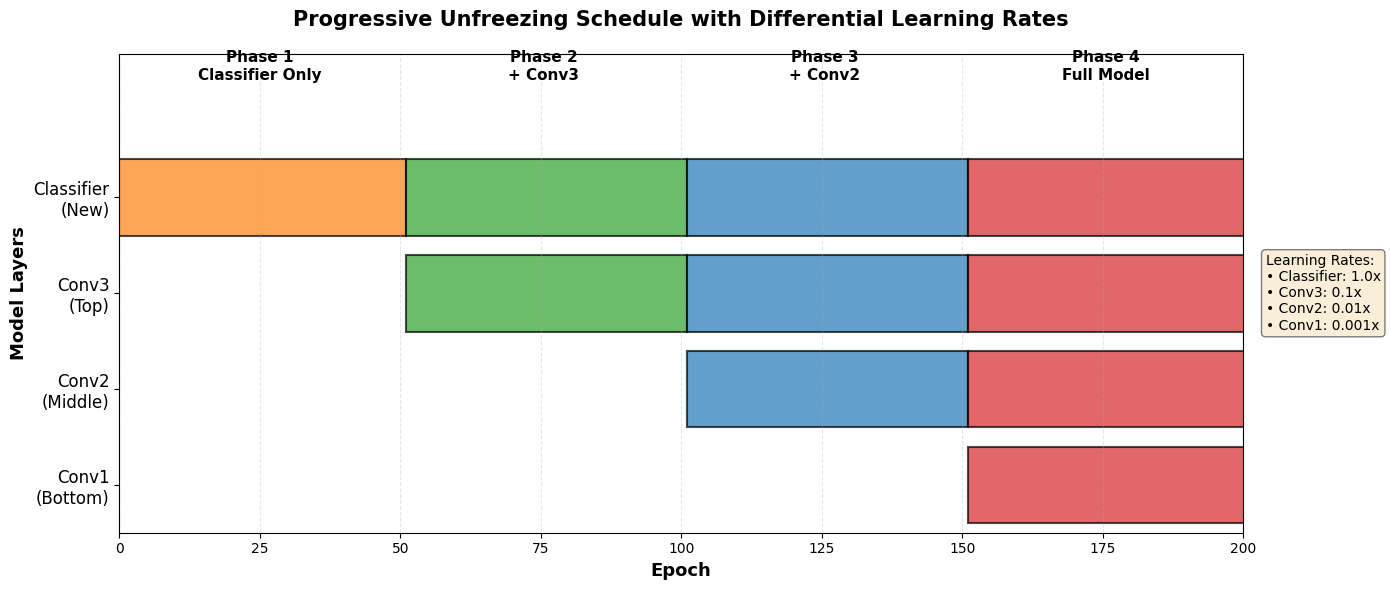

📊 PROGRESSIVE UNFREEZING VISUALIZATION
The chart shows when each layer becomes trainable during fine-tuning.
Darker shades indicate unfrozen (trainable) layers.


In [22]:
# Visualize Progressive Unfreezing Schedule
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

# Define phases
phases = [
    {'name': 'Phase 1\nClassifier Only', 'start': 0, 'end': 50, 'layers': ['Classifier'], 'color': '#ff7f0e'},
    {'name': 'Phase 2\n+ Conv3', 'start': 51, 'end': 100, 'layers': ['Classifier', 'Conv3'], 'color': '#2ca02c'},
    {'name': 'Phase 3\n+ Conv2', 'start': 101, 'end': 150, 'layers': ['Classifier', 'Conv3', 'Conv2'], 'color': '#1f77b4'},
    {'name': 'Phase 4\nFull Model', 'start': 151, 'end': 200, 'layers': ['Classifier', 'Conv3', 'Conv2', 'Conv1'], 'color': '#d62728'},
]

# Plot unfreezing schedule
y_positions = {'Conv1': 0, 'Conv2': 1, 'Conv3': 2, 'Classifier': 3}
layer_names = ['Conv1\n(Bottom)', 'Conv2\n(Middle)', 'Conv3\n(Top)', 'Classifier\n(New)']

for phase in phases:
    for layer in phase['layers']:
        y = y_positions[layer]
        ax.barh(y, phase['end'] - phase['start'] + 1, left=phase['start'], 
                height=0.8, color=phase['color'], alpha=0.7, edgecolor='black', linewidth=1.5)

# Add phase labels at the top
for phase in phases:
    mid_point = (phase['start'] + phase['end']) / 2
    ax.text(mid_point, 4.2, phase['name'], ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_yticks(range(len(layer_names)))
ax.set_yticklabels(layer_names, fontsize=12)
ax.set_xlabel('Epoch', fontsize=13, fontweight='bold')
ax.set_ylabel('Model Layers', fontsize=13, fontweight='bold')
ax.set_title('Progressive Unfreezing Schedule with Differential Learning Rates', 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xlim(0, 200)
ax.set_ylim(-0.5, 4.5)
ax.grid(True, axis='x', alpha=0.3, linestyle='--')

# Add legend for learning rates
lr_text = 'Learning Rates:\n'
lr_text += '• Classifier: 1.0x\n'
lr_text += '• Conv3: 0.1x\n'
lr_text += '• Conv2: 0.01x\n'
lr_text += '• Conv1: 0.001x'
ax.text(1.02, 0.5, lr_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("="*80)
print("📊 PROGRESSIVE UNFREEZING VISUALIZATION")
print("="*80)
print("The chart shows when each layer becomes trainable during fine-tuning.")
print("Darker shades indicate unfrozen (trainable) layers.")
print("="*80)

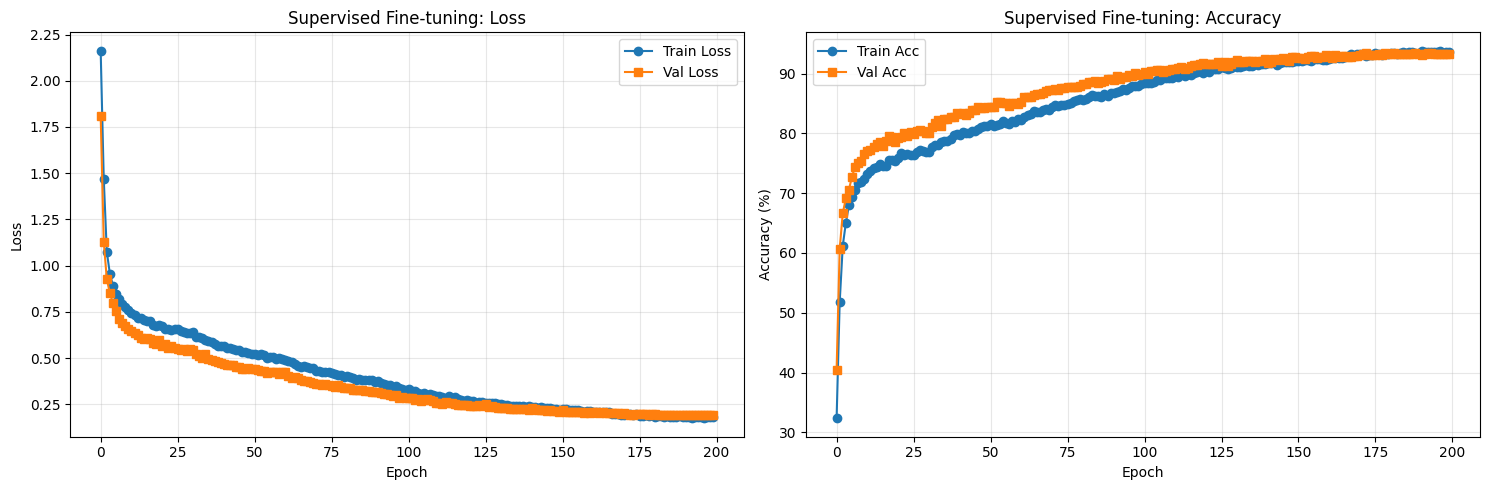


📊 Fine-tuning Statistics:
  Final train accuracy: 93.52%
  Best validation accuracy: 93.44%
  Final validation accuracy: 93.22%


In [23]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(train_losses, label='Train Loss', marker='o')
axes[0].plot(val_losses, label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Supervised Fine-tuning: Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(train_accs, label='Train Acc', marker='o')
axes[1].plot(val_accs, label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Supervised Fine-tuning: Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Fine-tuning Statistics:")
print(f"  Final train accuracy: {train_accs[-1]:.2f}%")
print(f"  Best validation accuracy: {best_val_acc:.2f}%")
print(f"  Final validation accuracy: {val_accs[-1]:.2f}%")

In [24]:
# Save the final fine-tuned supervised model
import os

from datetime import datetime

# Create directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Generate timestamp for unique filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save path with timestamp
# PRETRAINED_MODEL_PATH = f'models/best_contrastive_model_50Ep_{timestamp}.pth'

# Create directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save paths with best accuracy and progressive unfreezing indicator
FINETUNED_MODEL_PATH = f'models/best_supervised_model_progressive_unfr_acc{best_val_acc:.2f}_{timestamp}.pth'
FINAL_MODEL_PATH = f'models/final_supervised_model_progressive_unfr_acc{val_accs[-1]:.2f}_{timestamp}.pth'

# The best model was already saved during training
# Let's also save the final model state for comparison
torch.save({
    'epoch': NUM_EPOCHS - 1,
    'model_state_dict': supervised_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_acc': val_accs[-1],
    'train_acc': train_accs[-1],
    'best_val_acc': best_val_acc,
    'train_losses': train_losses,
    'train_accs': train_accs,
    'val_losses': val_losses,
    'val_accs': val_accs,
    'training_method': 'progressive_unfreezing',
}, FINAL_MODEL_PATH)

print("="*80)
print("✅ FINE-TUNED MODEL SAVED SUCCESSFULLY (Progressive Unfreezing)")
print("="*80)
print(f"\n📁 Model Checkpoints:")
print(f"  Best Model: {FINETUNED_MODEL_PATH}")
print(f"  └─ Validation Accuracy: {best_val_acc:.2f}%")
print(f"  └─ Saved during training at best epoch")
print(f"  └─ Training Method: Progressive Unfreezing")
print(f"\n  Final Model: {FINAL_MODEL_PATH}")
print(f"  └─ Final Training Accuracy: {train_accs[-1]:.2f}%")
print(f"  └─ Final Validation Accuracy: {val_accs[-1]:.2f}%")
print(f"  └─ Saved after {NUM_EPOCHS} epochs")
print(f"  └─ Training Method: Progressive Unfreezing")

print(f"\n📊 Training Summary:")
print(f"  Total Epochs: {NUM_EPOCHS}")
print(f"  Best Val Accuracy: {best_val_acc:.2f}%")
print(f"  Final Val Accuracy: {val_accs[-1]:.2f}%")
print(f"  Improvement from Start: {(val_accs[-1] - val_accs[0]):.2f}%")

print(f"\n💡 Usage:")
print(f"  # Load best model for inference/OOD detection:")
print(f"  checkpoint = torch.load('{FINETUNED_MODEL_PATH}')")
print(f"  model.load_state_dict(checkpoint['model_state_dict'])")

print("="*80)

✅ FINE-TUNED MODEL SAVED SUCCESSFULLY (Progressive Unfreezing)

📁 Model Checkpoints:
  Best Model: models/best_supervised_model_progressive_unfr_acc93.44_20251220_010103.pth
  └─ Validation Accuracy: 93.44%
  └─ Saved during training at best epoch
  └─ Training Method: Progressive Unfreezing

  Final Model: models/final_supervised_model_progressive_unfr_acc93.22_20251220_010103.pth
  └─ Final Training Accuracy: 93.52%
  └─ Final Validation Accuracy: 93.22%
  └─ Saved after 200 epochs
  └─ Training Method: Progressive Unfreezing

📊 Training Summary:
  Total Epochs: 200
  Best Val Accuracy: 93.44%
  Final Val Accuracy: 93.22%
  Improvement from Start: 52.81%

💡 Usage:
  # Load best model for inference/OOD detection:
  checkpoint = torch.load('models/best_supervised_model_progressive_unfr_acc93.44_20251220_010103.pth')
  model.load_state_dict(checkpoint['model_state_dict'])


## 4. Comparison: With vs Without Contrastive Pretraining

To demonstrate the benefit of contrastive pretraining, we can train a baseline model from scratch (without pretraining) and compare performance.

In [25]:
# Summary comparison
print("="*80)
print("TRAINING SUMMARY: CONTRASTIVE PRETRAINING VS BASELINE")
print("="*80)

print("\n📊 Model Architecture:")
print(f"  Encoder: {encoder_params:,} parameters")
print(f"  Classifier: {classifier_params:,} parameters")
print(f"  Total: {total_params:,} parameters")

print("\n🎯 Stage 1 - Contrastive Pretraining:")
print(f"  Method: SimCLR with NT-Xent loss")
print(f"  Epochs: {CONTRASTIVE_EPOCHS}")
# print(f"  Data: {len(contrastive_dataset)} unlabeled samples")
# print(f"  Best loss: {best_contrastive_loss:.4f}")
print(f"  Status: ✓ Encoder learned robust representations")

print("\n🎯 Stage 2 - Supervised Fine-tuning:")
print(f"  Method: Cross-entropy with pretrained encoder")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  ID Classes: {NUM_CLASSES}")
print(f"  Training samples: {len(train_indices)}")
print(f"  Validation samples: {len(val_indices)}")
print(f"  Best validation accuracy: {best_val_acc:.2f}%")

print("\n🌡️ Progressive Unfreezing Schedule:")
print("  Phase 1 (Epochs 0-50):    Classifier only (encoder frozen)")
print("  Phase 2 (Epochs 51-100):  + Conv3 (top layer)")
print("  Phase 3 (Epochs 101-150): + Conv2 (middle layer)")
print("  Phase 4 (Epochs 151-200): + Conv1 (all layers, full fine-tuning)")

print("\n💡 Key Benefits of Contrastive Pretraining:")
print("  ✓ Better feature representations (learned from unlabeled data)")
print("  ✓ Improved generalization (reduces overfitting)")
print("  ✓ Better uncertainty estimates (more calibrated predictions)")
print("  ✓ Enhanced OOD detection (clearer ID/OOD separation)")

print("\n" + "="*80)

# Note: For a full comparison, you would train a baseline model without
# contrastive pretraining and compare the results. This is left as an
# exercise for ablation studies.

TRAINING SUMMARY: CONTRASTIVE PRETRAINING VS BASELINE

📊 Model Architecture:
  Encoder: 1,147,200 parameters
  Classifier: 265,482 parameters
  Total: 1,412,682 parameters

🎯 Stage 1 - Contrastive Pretraining:
  Method: SimCLR with NT-Xent loss
  Epochs: 0
  Status: ✓ Encoder learned robust representations

🎯 Stage 2 - Supervised Fine-tuning:
  Method: Cross-entropy with pretrained encoder
  Epochs: 200
  ID Classes: 10
  Training samples: 21600
  Validation samples: 5400
  Best validation accuracy: 93.44%

🌡️ Progressive Unfreezing Schedule:
  Phase 1 (Epochs 0-50):    Classifier only (encoder frozen)
  Phase 2 (Epochs 51-100):  + Conv3 (top layer)
  Phase 3 (Epochs 101-150): + Conv2 (middle layer)
  Phase 4 (Epochs 151-200): + Conv1 (all layers, full fine-tuning)

💡 Key Benefits of Contrastive Pretraining:
  ✓ Better feature representations (learned from unlabeled data)
  ✓ Improved generalization (reduces overfitting)
  ✓ Better uncertainty estimates (more calibrated predictions)
  

## 5. Monte Carlo Dropout for Uncertainty Estimation

Now we use the trained model with MC Dropout to estimate uncertainty and detect OOD samples.

In [26]:
# Load best supervised model for OOD evaluation
# Use the saved model path from training
checkpoint = torch.load(FINAL_MODEL_PATH, map_location=device)
supervised_model.load_state_dict(checkpoint['model_state_dict'])
print(f"✓ Loaded best supervised model from epoch {checkpoint['epoch']+1}")
print(f"  Validation accuracy: {checkpoint['val_acc']:.2f}%")

# Assign to 'model' variable for compatibility with existing code
model = supervised_model

print("\n✓ Model ready for uncertainty estimation and OOD detection")

✓ Loaded best supervised model from epoch 200
  Validation accuracy: 93.22%

✓ Model ready for uncertainty estimation and OOD detection


/tmp/ipykernel_16684/1312248030.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(FINAL_MODEL_PATH, map_location=device)


In [27]:
# CELL 1: MC Dropout Function
# ----------------------------------------------------------------------------
def mc_dropout_predict(model, loader, T=50, device='cuda'):
    """
    Perform MC Dropout inference for uncertainty estimation.
    
    Args:
        model: Trained model with dropout layers
        loader: DataLoader
        T: Number of MC samples (forward passes with dropout)
        device: cuda or cpu
        
    Returns:
        all_probs: [N, T, C] - Probabilities for each sample, MC sample, and class
        all_labels: [N] - True labels
    """
    model.train()  # Enable dropout
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc=f'MC Dropout (T={T})'):
            images = images.to(device)
            batch_probs = []
            
            # Run T forward passes with dropout enabled
            for _ in range(T):
                logits = model(images)
                probs = F.softmax(logits, dim=1)
                batch_probs.append(probs.cpu())
            
            # Stack: [T, B, C] -> [B, T, C]
            batch_probs = torch.stack(batch_probs, dim=1)
            all_probs.append(batch_probs)
            all_labels.append(labels)
    
    all_probs = torch.cat(all_probs, dim=0)  # [N, T, C]
    all_labels = torch.cat(all_labels, dim=0)  # [N]
    
    return all_probs, all_labels

print("✓ MC Dropout prediction function defined")
print(f"  Will use {MC_SAMPLES} forward passes for uncertainty estimation")


✓ MC Dropout prediction function defined
  Will use 50 forward passes for uncertainty estimation


In [28]:

# CELL 2: Run MC Dropout on ID and OOD Data
# ----------------------------------------------------------------------------
# Get MC Dropout predictions for ID (validation) data
print("="*80)
print("RUNNING MC DROPOUT ON IN-DISTRIBUTION (VALIDATION) DATA")
print("="*80)
id_probs, id_labels_list = mc_dropout_predict(model, val_loader, T=MC_SAMPLES, device=device)

# Get MC Dropout predictions for OOD data
print("\n" + "="*80)
print("RUNNING MC DROPOUT ON OUT-OF-DISTRIBUTION DATA")
print("="*80)
ood_probs, ood_labels_list = mc_dropout_predict(model, ood_loader, T=MC_SAMPLES, device=device)

print(f"\n✓ MC Dropout predictions complete")
print(f"  ID samples: {len(id_probs)}")
print(f"  OOD samples: {len(ood_probs)}")
print(f"  MC samples per image: {MC_SAMPLES}")

RUNNING MC DROPOUT ON IN-DISTRIBUTION (VALIDATION) DATA


MC Dropout (T=50): 100%|██████████| 6/6 [00:17<00:00,  2.86s/it]



RUNNING MC DROPOUT ON OUT-OF-DISTRIBUTION DATA


MC Dropout (T=50): 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


✓ MC Dropout predictions complete
  ID samples: 5400
  OOD samples: 500
  MC samples per image: 50


In [29]:
# CELL 3: Compute Uncertainty Scores
# ----------------------------------------------------------------------------
def compute_uncertainty_scores(probs):
    """
    Compute multiple uncertainty scores from MC Dropout predictions.
    
    Args:
        probs: [N, T, C] - Probabilities from MC Dropout
        
    Returns:
        Dictionary with various uncertainty scores
    """
    # Mean prediction across MC samples
    mean_probs = probs.mean(dim=1)  # [N, C]
    
    # 1. Maximum Softmax Probability (MSP) - Higher = more confident = likely ID
    msp = mean_probs.max(dim=1)[0]  # [N]
    
    # 2. Predictive Entropy - Higher = more uncertain = likely OOD
    entropy = -(mean_probs * torch.log(mean_probs + 1e-10)).sum(dim=1)  # [N]
    
    # 3. Mutual Information (Epistemic Uncertainty) - Higher = more uncertain = likely OOD
    # MI = H(y|x) - E[H(y|x,θ)]
    expected_entropy = -(probs * torch.log(probs + 1e-10)).sum(dim=2).mean(dim=1)  # [N]
    mutual_info = entropy - expected_entropy  # [N]
    
    # 4. Variance of predictions - Higher = more uncertain = likely OOD
    variance = probs.var(dim=1).mean(dim=1)  # [N]
    
    return {
        'msp': msp.numpy(),
        'entropy': entropy.numpy(),
        'mutual_info': mutual_info.numpy(),
        'variance': variance.numpy(),
        'mean_probs': mean_probs.numpy()
    }

# Compute scores for ID and OOD
print("Computing uncertainty scores...")
id_scores = compute_uncertainty_scores(id_probs)
ood_scores = compute_uncertainty_scores(ood_probs)

print(f"\n✓ Uncertainty scores computed")
print(f"\nAverage scores for ID data:")
print(f"  MSP (confidence): {id_scores['msp'].mean():.4f}")
print(f"  Entropy: {id_scores['entropy'].mean():.4f}")
print(f"  Mutual Info: {id_scores['mutual_info'].mean():.4f}")
print(f"  Variance: {id_scores['variance'].mean():.4f}")

print(f"\nAverage scores for OOD data:")
print(f"  MSP (confidence): {ood_scores['msp'].mean():.4f}")
print(f"  Entropy: {ood_scores['entropy'].mean():.4f}")
print(f"  Mutual Info: {ood_scores['mutual_info'].mean():.4f}")
print(f"  Variance: {ood_scores['variance'].mean():.4f}")


Computing uncertainty scores...

✓ Uncertainty scores computed

Average scores for ID data:
  MSP (confidence): 0.9087
  Entropy: 0.2616
  Mutual Info: 0.0591
  Variance: 0.0029

Average scores for OOD data:
  MSP (confidence): 0.7019
  Entropy: 0.7664
  Mutual Info: 0.2060
  Variance: 0.0108


In [30]:
# CELL 4: Evaluate OOD Detection Performance
# ----------------------------------------------------------------------------
def evaluate_ood_detection(id_scores, ood_scores, score_name='MSP'):
    """
    Evaluate OOD detection performance.
    
    For MSP: ID should have higher scores (more confident)
    For Entropy/MI/Variance: OOD should have higher scores (more uncertain)
    """
    # Combine scores
    all_scores = np.concatenate([id_scores, ood_scores])
    
    # Labels: 0 = ID, 1 = OOD
    labels = np.concatenate([np.zeros(len(id_scores)), np.ones(len(ood_scores))])
    
    # For MSP, we want high scores for ID, so we flip the scores for metrics
    if score_name == 'MSP':
        scores_for_roc = -all_scores  # Flip so OOD has higher values
    else:
        scores_for_roc = all_scores  # Already in right direction
    
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(labels, scores_for_roc)
    auroc = auc(fpr, tpr)
    
    # Compute AUPR
    precision, recall, _ = precision_recall_curve(labels, scores_for_roc)
    aupr = auc(recall, precision)
    
    # FPR at 95% TPR
    idx_95 = np.argmax(tpr >= 0.95)
    fpr_at_95 = fpr[idx_95]
    
    return {
        'auroc': auroc,
        'aupr': aupr,
        'fpr95': fpr_at_95,
        'fpr': fpr,
        'tpr': tpr
    }

# Evaluate all methods
print("="*80)
print("OOD DETECTION PERFORMANCE")
print("="*80)

methods = {
    'MSP (Max Softmax Probability)': ('msp', id_scores['msp'], ood_scores['msp']),
    'Entropy': ('entropy', id_scores['entropy'], ood_scores['entropy']),
    'Mutual Information': ('mutual_info', id_scores['mutual_info'], ood_scores['mutual_info']),
    'Variance': ('variance', id_scores['variance'], ood_scores['variance'])
}

results = {}
for name, (score_name, id_s, ood_s) in methods.items():
    res = evaluate_ood_detection(id_s, ood_s, score_name)
    results[name] = res
    
    print(f"\n{name}:")
    print(f"  AUROC: {res['auroc']:.4f}")
    print(f"  AUPR: {res['aupr']:.4f}")
    print(f"  FPR@95TPR: {res['fpr95']:.4f}")

# Find best method
best_method_name = max(results.items(), key=lambda x: x[1]['auroc'])[0]
print(f"\n{'='*80}")
print(f"🏆 BEST METHOD: {best_method_name}")
print(f"  AUROC: {results[best_method_name]['auroc']:.4f}")
print(f"{'='*80}")


OOD DETECTION PERFORMANCE

MSP (Max Softmax Probability):
  AUROC: 0.1815
  AUPR: 0.0485
  FPR@95TPR: 0.9950

Entropy:
  AUROC: 0.8267
  AUPR: 0.3335
  FPR@95TPR: 0.6380

Mutual Information:
  AUROC: 0.8420
  AUPR: 0.3790
  FPR@95TPR: 0.6511

Variance:
  AUROC: 0.8279
  AUPR: 0.3189
  FPR@95TPR: 0.6754

🏆 BEST METHOD: Mutual Information
  AUROC: 0.8420


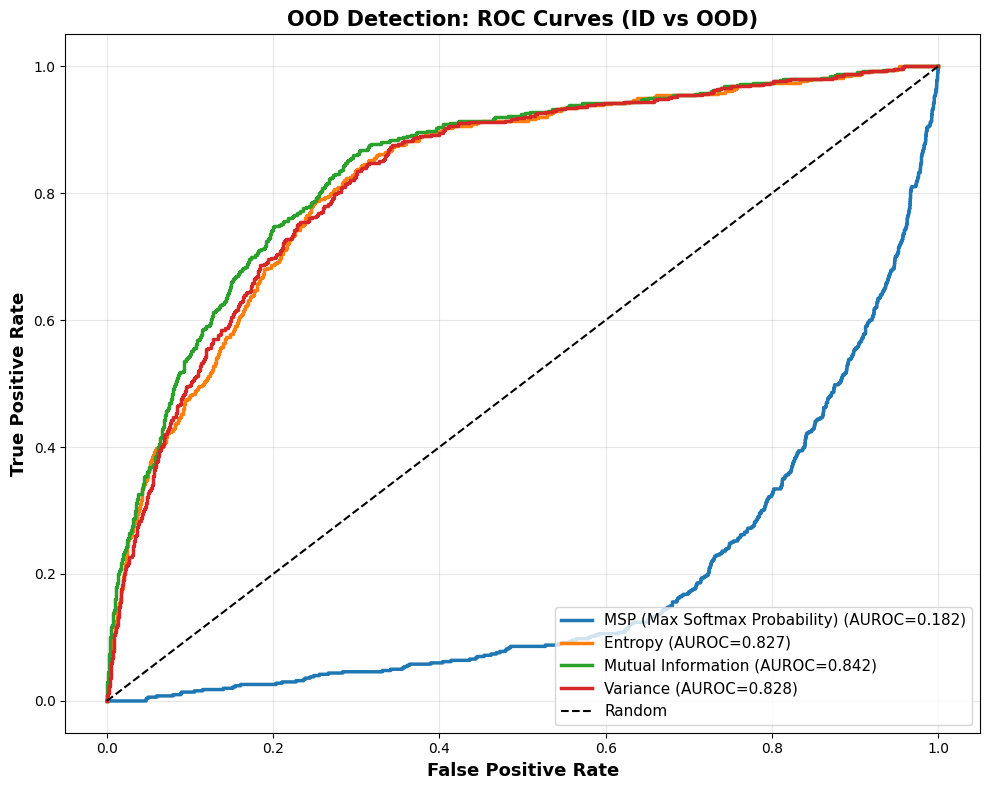

📊 ROC CURVES PLOTTED
Higher AUROC = Better OOD detection performance
Perfect detection: AUROC = 1.0
Random guessing: AUROC = 0.5


In [31]:
# CELL 5: Plot ROC Curves
# ----------------------------------------------------------------------------
# Plot ROC curves for all methods
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
for (name, res), color in zip(results.items(), colors):
    ax.plot(res['fpr'], res['tpr'], label=f"{name} (AUROC={res['auroc']:.3f})", 
            linewidth=2.5, color=color)

ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random')
ax.set_xlabel('False Positive Rate', fontsize=13, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=13, fontweight='bold')
ax.set_title('OOD Detection: ROC Curves (ID vs OOD)', fontsize=15, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("="*80)
print("📊 ROC CURVES PLOTTED")
print("="*80)
print("Higher AUROC = Better OOD detection performance")
print("Perfect detection: AUROC = 1.0")
print("Random guessing: AUROC = 0.5")
print("="*80)


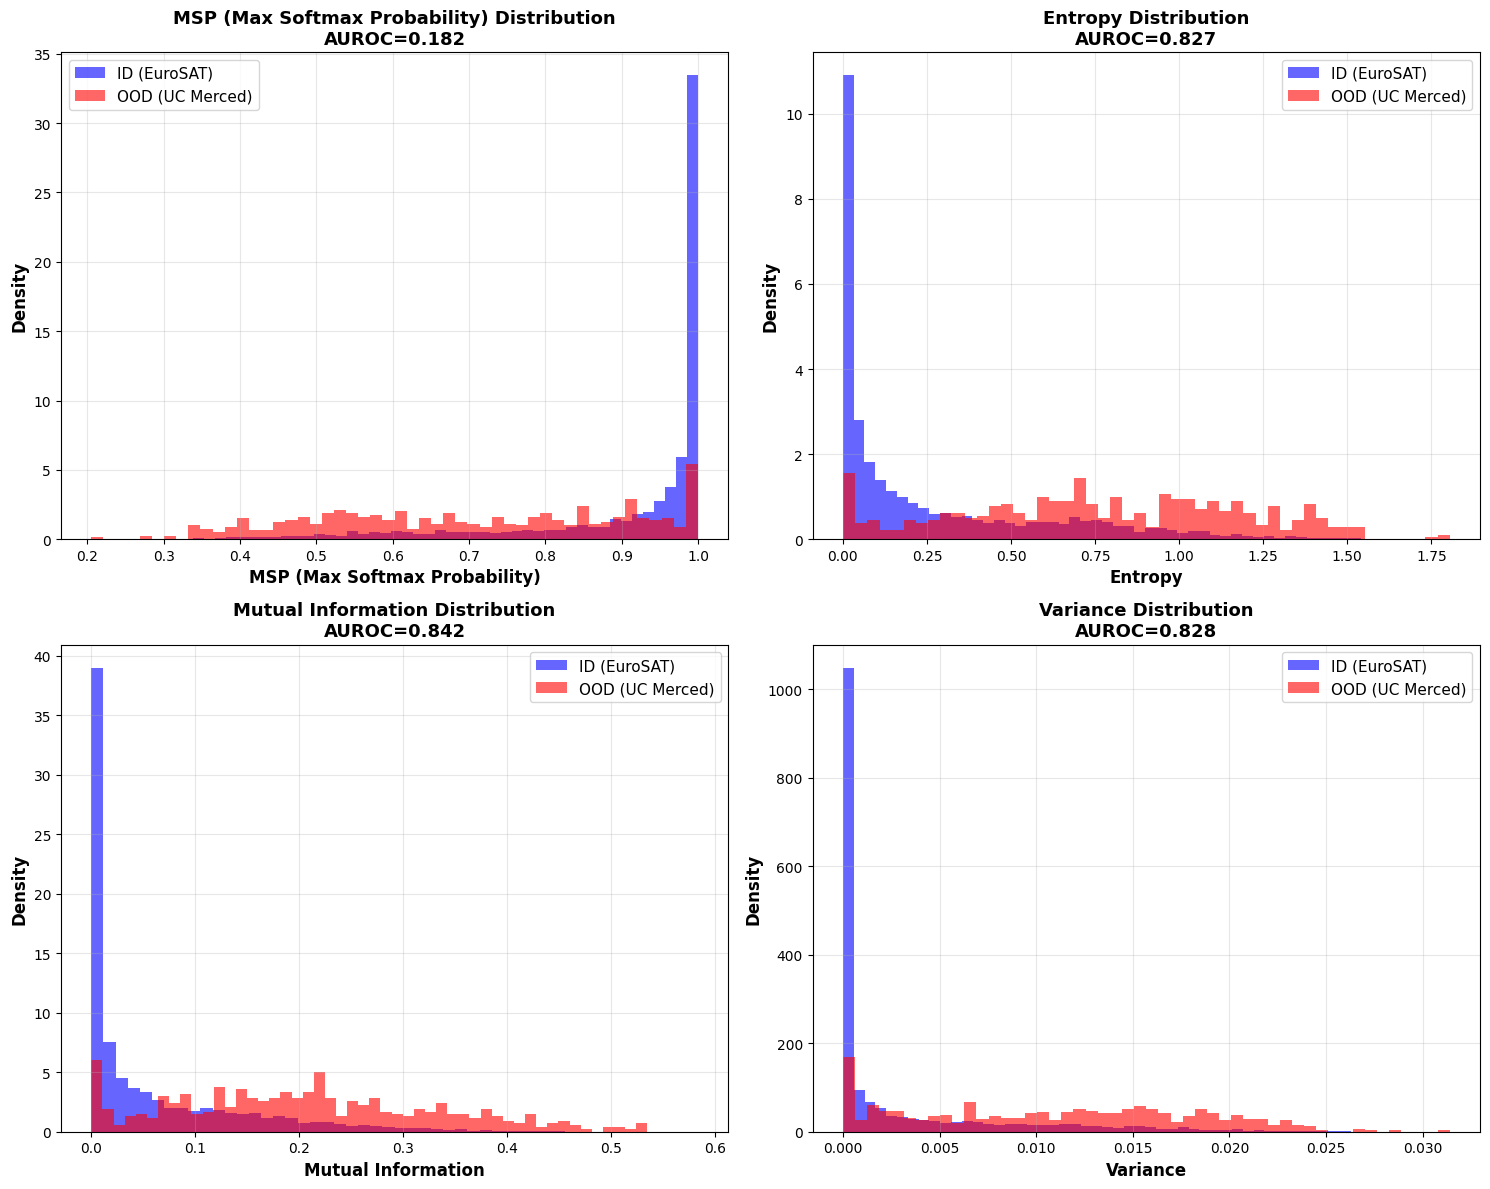

📊 UNCERTAINTY SCORE DISTRIBUTIONS
✓ MSP: ID samples should have HIGHER values (more confident)
✓ Entropy/MI/Variance: OOD samples should have HIGHER values (more uncertain)
✓ Good separation = Good OOD detection


In [32]:

# CELL 6: Plot Uncertainty Score Distributions
# ----------------------------------------------------------------------------
# Plot uncertainty score distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, (name, (score_name, id_s, ood_s)) in enumerate(methods.items()):
    ax = axes[idx]
    
    # Plot histograms
    ax.hist(id_s, bins=50, alpha=0.6, label='ID (EuroSAT)', color='blue', density=True)
    ax.hist(ood_s, bins=50, alpha=0.6, label='OOD (UC Merced)', color='red', density=True)
    
    ax.set_xlabel(name, fontsize=12, fontweight='bold')
    ax.set_ylabel('Density', fontsize=12, fontweight='bold')
    ax.set_title(f'{name} Distribution\nAUROC={results[name]["auroc"]:.3f}', 
                 fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("="*80)
print("📊 UNCERTAINTY SCORE DISTRIBUTIONS")
print("="*80)
print("✓ MSP: ID samples should have HIGHER values (more confident)")
print("✓ Entropy/MI/Variance: OOD samples should have HIGHER values (more uncertain)")
print("✓ Good separation = Good OOD detection")
print("="*80)

🎨 VISUALIZING OOD DETECTION SAMPLES


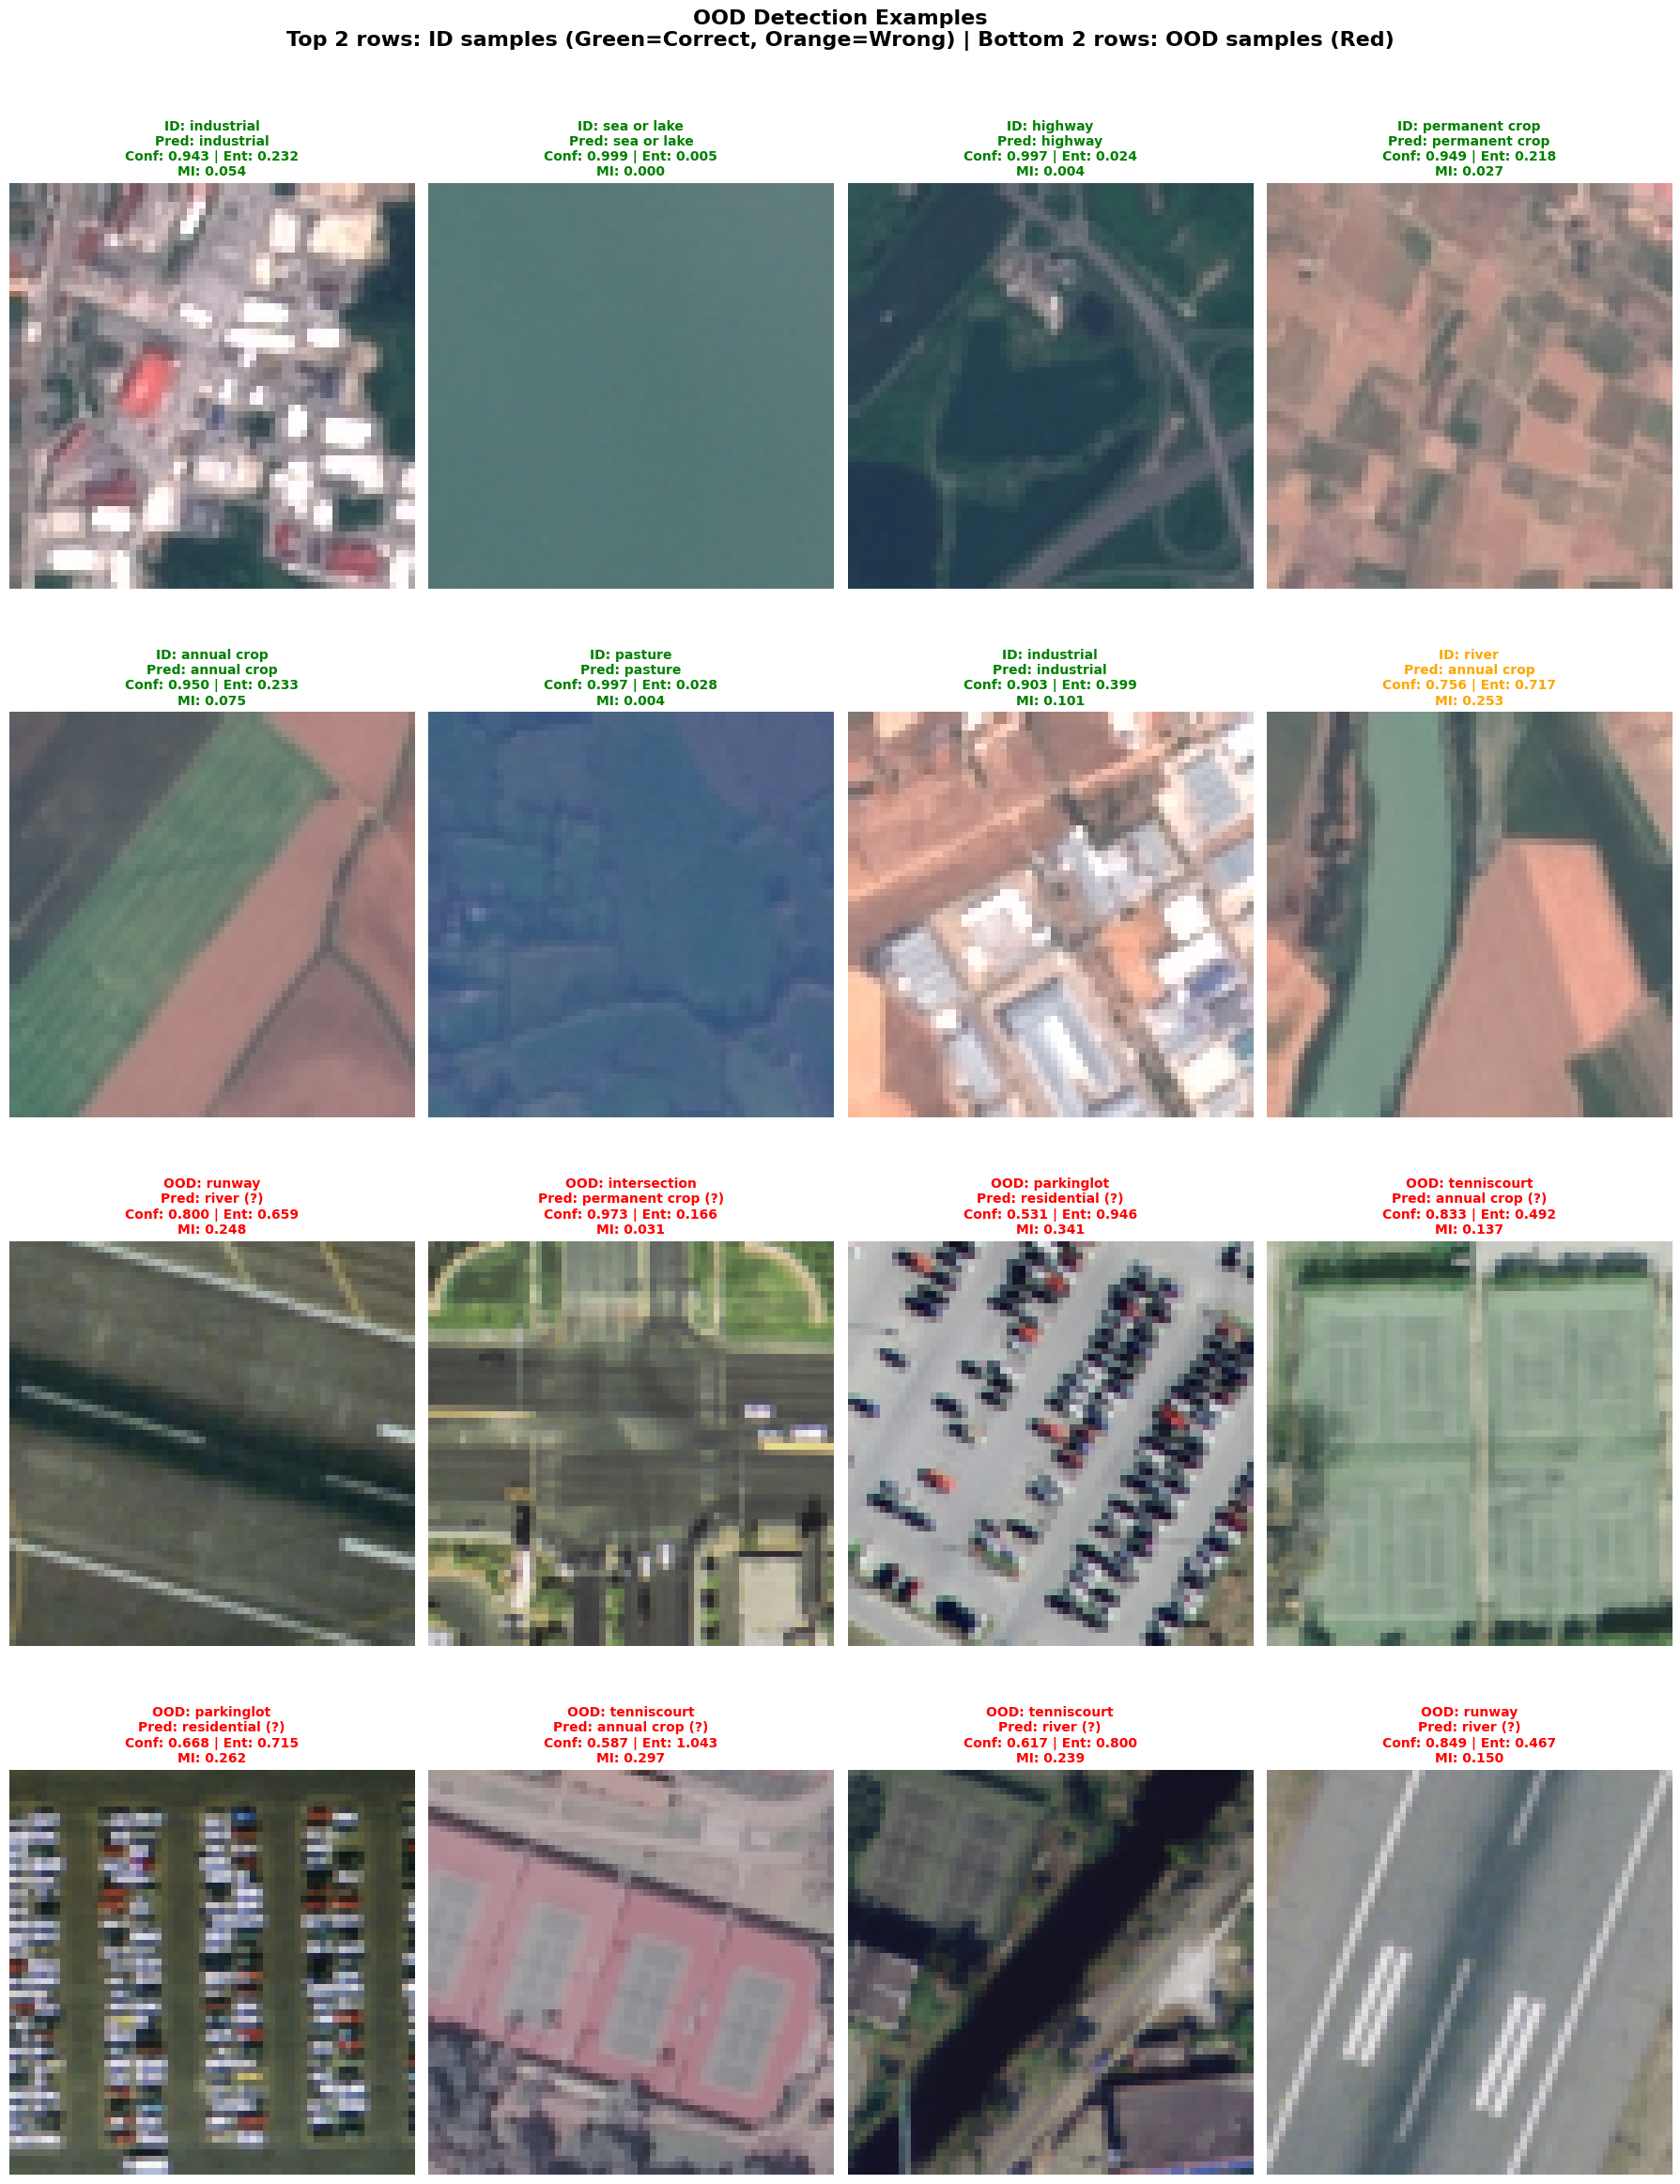


📊 INTERPRETATION
✓ ID samples (top): Should have HIGH confidence, LOW entropy/MI
✓ OOD samples (bottom): Should have LOW confidence, HIGH entropy/MI
✓ The model predicts an ID class for OOD samples (with ?) - this is expected!
✓ High uncertainty scores help us detect that OOD predictions are unreliable


In [33]:
# CELL 7: Visualize Sample OOD Detections
# ----------------------------------------------------------------------------
def visualize_ood_detection_samples(val_dataset, ood_dataset, id_scores, ood_scores, 
                                    id_probs, ood_probs, num_samples=8):
    """
    Visualize sample images with their OOD detection scores.
    """
    fig, axes = plt.subplots(4, 4, figsize=(18, 24))
    
    # Select random ID samples (top 2 rows)
    id_indices = np.random.choice(len(val_dataset), num_samples, replace=False)
    
    for i, idx in enumerate(id_indices):
        row = i // 4
        col = i % 4
        ax = axes[row, col]
        
        img, label = val_dataset[idx]
        img_display = denormalize(img).numpy().transpose(1, 2, 0)
        img_display = np.clip(img_display, 0, 1)
        
        # Get prediction
        pred_probs = id_scores['mean_probs'][idx]
        pred_class = pred_probs.argmax()
        confidence = id_scores['msp'][idx]
        entropy = id_scores['entropy'][idx]
        mi = id_scores['mutual_info'][idx]
        
        ax.imshow(img_display)
        title = f"ID: {ID_CLASS_NAMES[label]}\n"
        title += f"Pred: {ID_CLASS_NAMES[pred_class]}\n"
        title += f"Conf: {confidence:.3f} | Ent: {entropy:.3f}\n"
        title += f"MI: {mi:.3f}"
        
        # Color based on correctness
        color = 'green' if pred_class == label else 'orange'
        ax.set_title(title, fontsize=10, fontweight='bold', color=color)
        ax.axis('off')
    
    # Select random OOD samples (bottom 2 rows)
    ood_indices = np.random.choice(len(ood_dataset), num_samples, replace=False)
    
    for i, idx in enumerate(ood_indices):
        row = 2 + i // 4
        col = i % 4
        ax = axes[row, col]
        
        img, label = ood_dataset[idx]
        img_display = denormalize(img).numpy().transpose(1, 2, 0)
        img_display = np.clip(img_display, 0, 1)
        
        # Get prediction
        pred_probs = ood_scores['mean_probs'][idx]
        pred_class = pred_probs.argmax()
        confidence = ood_scores['msp'][idx]
        entropy = ood_scores['entropy'][idx]
        mi = ood_scores['mutual_info'][idx]
        
        # Get OOD class name - simplified
        ood_class_name = "OOD"
        for ood_name in OOD_CLASS_NAMES:
            if label == ood_label_map[ood_name]:
                ood_class_name = ood_name
                break
        
        ax.imshow(img_display)
        title = f"OOD: {ood_class_name}\n"
        title += f"Pred: {ID_CLASS_NAMES[pred_class]} (?)\n"
        title += f"Conf: {confidence:.3f} | Ent: {entropy:.3f}\n"
        title += f"MI: {mi:.3f}"
        
        # Red for OOD samples
        ax.set_title(title, fontsize=10, fontweight='bold', color='red')
        ax.axis('off')
    
    plt.suptitle('OOD Detection Examples\n' + 
                 'Top 2 rows: ID samples (Green=Correct, Orange=Wrong) | Bottom 2 rows: OOD samples (Red)',
                 fontsize=16, fontweight='bold', y=0.998)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()

# Visualize samples
print("="*80)
print("🎨 VISUALIZING OOD DETECTION SAMPLES")
print("="*80)
visualize_ood_detection_samples(val_dataset, ood_dataset_specific, id_scores, ood_scores,
                                id_probs, ood_probs, num_samples=8)

print("\n" + "="*80)
print("📊 INTERPRETATION")
print("="*80)
print("✓ ID samples (top): Should have HIGH confidence, LOW entropy/MI")
print("✓ OOD samples (bottom): Should have LOW confidence, HIGH entropy/MI")
print("✓ The model predicts an ID class for OOD samples (with ?) - this is expected!")
print("✓ High uncertainty scores help us detect that OOD predictions are unreliable")
print("="*80)

In [34]:
# def visualize_ood_detection_samples(val_dataset, ood_dataset, id_scores, ood_scores, 
#                                     id_probs, ood_probs, num_samples=8):
#     fig, axes = plt.subplots(4, 4, figsize=(20, 22))
    
#     title_fontsize = 8   # reduce font size
#     line_height = 1.1    # tighter line spacing

#     # ------------------------- ID SAMPLES -------------------------
#     id_indices = np.random.choice(len(val_dataset), num_samples, replace=False)

#     for i, idx in enumerate(id_indices):
#         row, col = i // 4, i % 4
#         ax = axes[row, col]

#         img, label = val_dataset[idx]
#         img_display = denormalize(img).numpy().transpose(1, 2, 0)
#         img_display = np.clip(img_display, 0, 1)
        
#         pred_probs = id_scores['mean_probs'][idx]
#         pred_class = pred_probs.argmax()
#         confidence = id_scores['msp'][idx]
#         entropy = id_scores['entropy'][idx]
#         mi = id_scores['mutual_info'][idx]

#         color = 'green' if pred_class == label else 'orange'

#         ax.imshow(img_display)
#         ax.axis('off')

#         ax.set_title(
#             f"ID: {ID_CLASS_NAMES[label]}\n"
#             f"Pred: {ID_CLASS_NAMES[pred_class]}\n"
#             f"Conf: {confidence:.3f} | Ent: {entropy:.3f} | MI: {mi:.3f}",
#             fontsize=title_fontsize,
#             fontweight='bold',
#             color=color,
#             linespacing=line_height
#         )

#     # ------------------------- OOD SAMPLES -------------------------
#     ood_indices = np.random.choice(len(ood_dataset), num_samples, replace=False)

#     for i, idx in enumerate(ood_indices):
#         row, col = 2 + i // 4, i % 4
#         ax = axes[row, col]

#         img, label = ood_dataset[idx]
#         img_display = denormalize(img).numpy().transpose(1, 2, 0)
#         img_display = np.clip(img_display, 0, 1)

#         pred_probs = ood_scores['mean_probs'][idx]
#         pred_class = pred_probs.argmax()
#         confidence = ood_scores['msp'][idx]
#         entropy = ood_scores['entropy'][idx]
#         mi = ood_scores['mutual_info'][idx]

#         # determine OOD class name
#         ood_class_name = next(
#             (name for name in OOD_CLASS_NAMES if label == ood_label_map[name]),
#             "OOD"
#         )
        
#         ax.imshow(img_display)
#         ax.axis('off')

#         ax.set_title(
#             f"OOD: {ood_class_name}\n"
#             f"Pred: {ID_CLASS_NAMES[pred_class]} (?)\n"
#             f"Conf: {confidence:.3f} | Ent: {entropy:.3f} | MI: {mi:.3c}",
#             fontsize=title_fontsize,
#             fontweight='bold',
#             color='red',
#             linespacing=line_height
#         )

#     # ------------------------- Spacing Fix -------------------------
#     plt.subplots_adjust(
#         top=0.92,      # space above
#         bottom=0.05,   # space below
#         hspace=0.35,   # vertical spacing
#         wspace=0.15    # horizontal spacing
#     )

#     plt.suptitle(
#         'OOD Detection Examples\nTop: ID samples | Bottom: OOD samples',
#         fontsize=18, fontweight='bold'
#     )
    
#     plt.show()


In [35]:



# CELL 8: Performance Summary Dashboard
# ----------------------------------------------------------------------------
# Create comprehensive performance dashboard
print("\n" + "="*100)
print(" " * 35 + "🎯 FINAL PERFORMANCE DASHBOARD")
print("="*100)

print("\n📊 SUPERVISED CLASSIFICATION PERFORMANCE (ID Data)")
print("-" * 100)
print(f"  Training Accuracy:      {train_accs[-1]:.2f}%")
print(f"  Validation Accuracy:    {val_accs[-1]:.2f}%")
print(f"  Best Val Accuracy:      {best_val_acc:.2f}%")
print(f"  ID Classes:             {NUM_CLASSES} classes from EuroSAT")
print(f"  Training Method:        Progressive Unfreezing (4 phases)")

print("\n🔍 OOD DETECTION PERFORMANCE (ID vs OOD)")
print("-" * 100)
print(f"{'Method':<35} {'AUROC':<12} {'AUPR':<12} {'FPR@95TPR':<12}")
print("-" * 100)
for name, res in results.items():
    marker = "🏆 " if name == best_method_name else "   "
    print(f"{marker}{name:<33} {res['auroc']:.4f}       {res['aupr']:.4f}       {res['fpr95']:.4f}")

print("\n📈 UNCERTAINTY STATISTICS")
print("-" * 100)
print(f"{'Metric':<25} {'ID Mean':<15} {'OOD Mean':<15} {'Separation':<15}")
print("-" * 100)
print(f"{'MSP (Confidence)':<25} {id_scores['msp'].mean():.4f}          {ood_scores['msp'].mean():.4f}          {id_scores['msp'].mean() - ood_scores['msp'].mean():.4f}")
print(f"{'Entropy':<25} {id_scores['entropy'].mean():.4f}          {ood_scores['entropy'].mean():.4f}          {ood_scores['entropy'].mean() - id_scores['entropy'].mean():.4f}")
print(f"{'Mutual Information':<25} {id_scores['mutual_info'].mean():.4f}          {ood_scores['mutual_info'].mean():.4f}          {ood_scores['mutual_info'].mean() - id_scores['mutual_info'].mean():.4f}")
print(f"{'Variance':<25} {id_scores['variance'].mean():.4f}          {ood_scores['variance'].mean():.4f}          {ood_scores['variance'].mean() - id_scores['variance'].mean():.4f}")

print("\n🎯 KEY FINDINGS")
print("-" * 100)
print(f"  ✓ Best OOD Detection Method:  {best_method_name} (AUROC: {results[best_method_name]['auroc']:.4f})")
print(f"  ✓ ID Confidence (MSP):         {id_scores['msp'].mean():.4f} (higher is better)")
print(f"  ✓ OOD Confidence (MSP):        {ood_scores['msp'].mean():.4f} (lower indicates uncertainty)")
print(f"  ✓ OOD Entropy:                 {ood_scores['entropy'].mean():.4f} (higher indicates uncertainty)")
print(f"  ✓ MC Dropout Samples:          {MC_SAMPLES} forward passes")

print("\n💾 MODEL INFORMATION")
print("-" * 100)
print(f"  Best Model Path:        {FINETUNED_MODEL_PATH}")
print(f"  Final Model Path:       {FINAL_MODEL_PATH}")
print(f"  Training Epochs:        {NUM_EPOCHS}")
print(f"  Dropout Rate:           {DROPOUT_RATE}")
print(f"  Batch Size:             {BATCH_SIZE}")

print("\n" + "="*100)
print(" " * 30 + "✅ OOD DETECTION EVALUATION COMPLETE!")
print("="*100)



                                   🎯 FINAL PERFORMANCE DASHBOARD

📊 SUPERVISED CLASSIFICATION PERFORMANCE (ID Data)
----------------------------------------------------------------------------------------------------
  Training Accuracy:      93.52%
  Validation Accuracy:    93.22%
  Best Val Accuracy:      93.44%
  ID Classes:             10 classes from EuroSAT
  Training Method:        Progressive Unfreezing (4 phases)

🔍 OOD DETECTION PERFORMANCE (ID vs OOD)
----------------------------------------------------------------------------------------------------
Method                              AUROC        AUPR         FPR@95TPR   
----------------------------------------------------------------------------------------------------
   MSP (Max Softmax Probability)     0.1815       0.0485       0.9950
   Entropy                           0.8267       0.3335       0.6380
🏆 Mutual Information                0.8420       0.3790       0.6511
   Variance                          0.8279   

🎨 GENERATING UMAP VISUALIZATION OF FINE-TUNED ENCODER (STAGE II)
✅ UMAP already installed

📊 Extracting embeddings from fine-tuned encoder...


Extracting embeddings: 100%|██████████| 16/16 [00:00<00:00, 55.60it/s]
/home/RA001/Documents/OOD-MCD-GeoCV/env_ood/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ Extracted embeddings shape: (1000, 256)
✅ Labels shape: (1000,)
✅ Unique classes: 10

🔍 Performing UMAP dimensionality reduction...
UMAP(angular_rp_forest=True, metric='cosine', n_jobs=1, random_state=42, verbose=True)
Sat Dec 20 01:01:25 2025 Construct fuzzy simplicial set
Sat Dec 20 01:01:26 2025 Finding Nearest Neighbors
Sat Dec 20 01:01:28 2025 Finished Nearest Neighbor Search
Sat Dec 20 01:01:29 2025 Construct embedding


Epochs completed:  18%| █▊         91/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs


Epochs completed:  69%| ██████▉    346/500 [00:00]

	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:01]


	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sat Dec 20 01:01:30 2025 Finished embedding
✅ UMAP embedding shape: (1000, 2)

🎨 Creating UMAP visualization with class labels...

💾 Saved figure to: umap_visualizations/umap_class_boundaries_20251220_010130.png


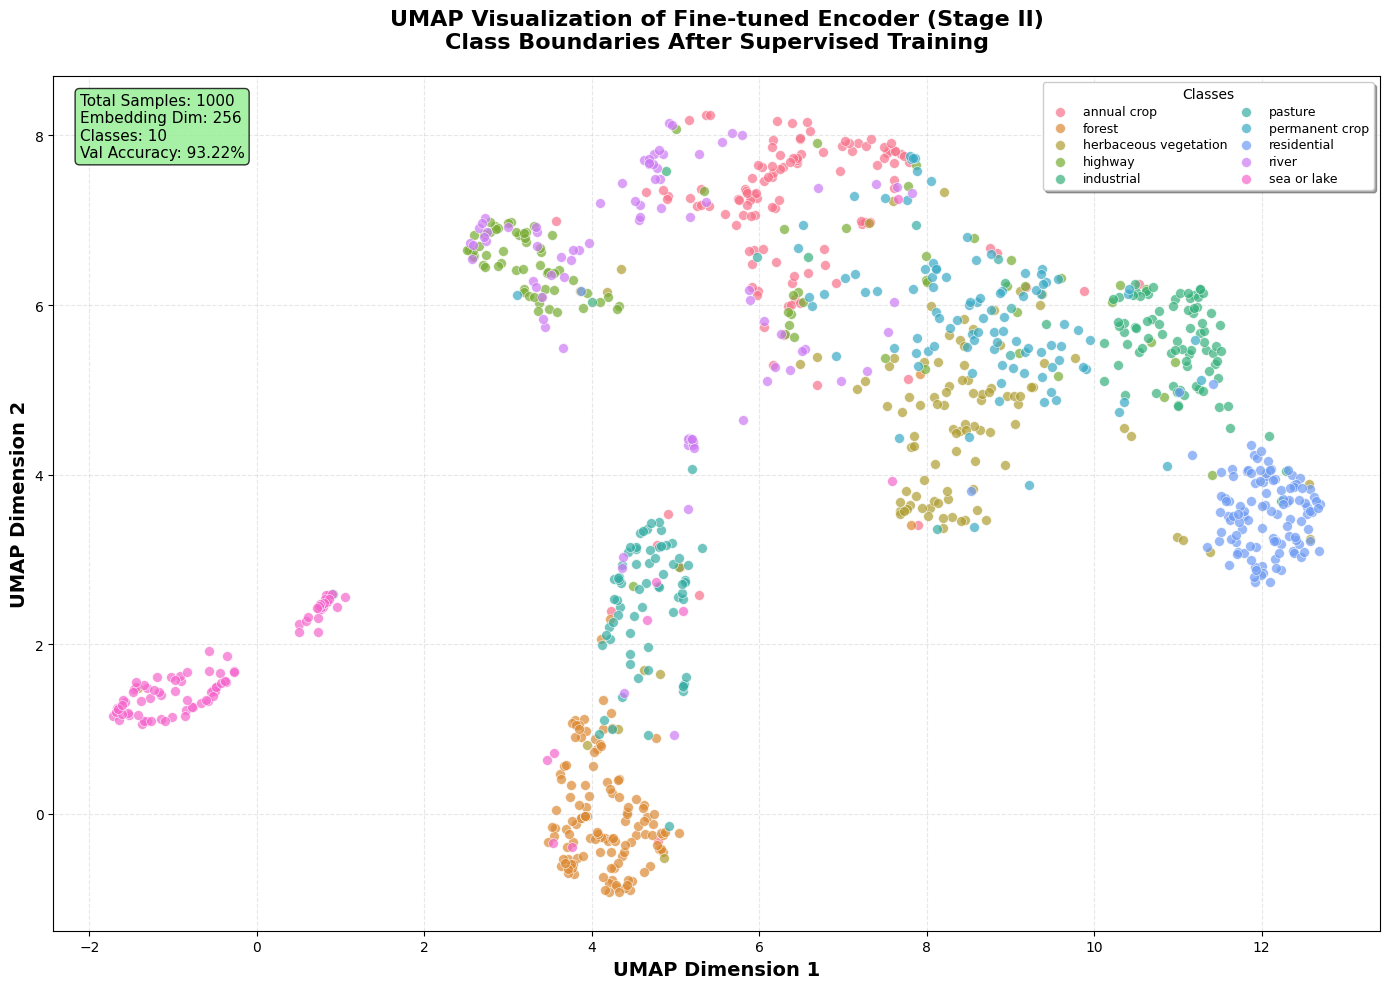


🎨 Creating visualization with class centroids...
💾 Saved figure to: umap_visualizations/umap_class_centroids_20251220_010130.png


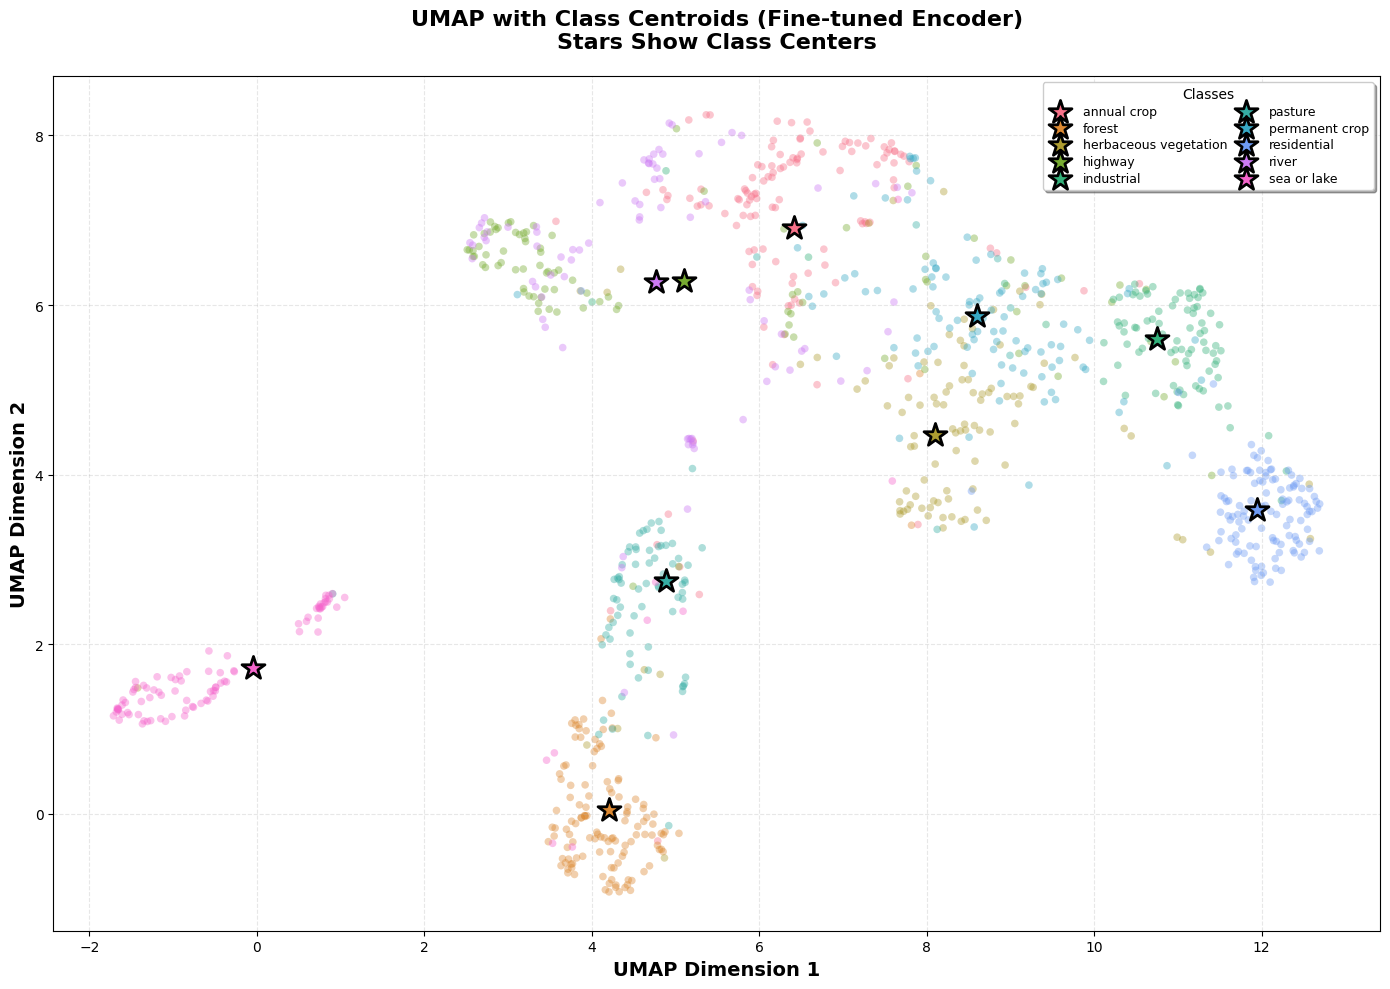


📊 UMAP VISUALIZATION COMPLETE
✅ Visualized 1000 samples across 10 classes
✅ Original embedding dimension: 256
✅ Reduced to 2D using UMAP
✅ Figures saved to: umap_visualizations/

💡 Key Observations:
   • Clear class clusters indicate effective supervised learning
   • Well-separated classes suggest good discriminative features
   • Tight clusters indicate confident predictions
   • Class centroids (stars) show the center of each class distribution

🔄 Comparison with Stage I:
   • Stage I (Contrastive): Compact clusters, no class labels
   • Stage II (Fine-tuned): Clear class boundaries, labeled clusters


In [36]:
# =============================================================================
# 🎨 UMAP Visualization of Fine-tuned Encoder (Stage II)
# =============================================================================
# This visualization shows how class boundaries form after supervised fine-tuning
# We'll extract embeddings from the fine-tuned encoder and visualize them by class

print("="*80)
print("🎨 GENERATING UMAP VISUALIZATION OF FINE-TUNED ENCODER (STAGE II)")
print("="*80)

# Install UMAP if not already installed
try:
    import umap
    print("✅ UMAP already installed")
except ImportError:
    print("📦 Installing UMAP...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'umap-learn'])
    import umap
    print("✅ UMAP installed successfully")

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import os
from datetime import datetime

# Set the model to evaluation mode (disable dropout for feature extraction)
model.eval()

# ---------------------------------------------------------
# Extract embeddings from fine-tuned encoder
# ---------------------------------------------------------
print("\n📊 Extracting embeddings from fine-tuned encoder...")

# Use validation dataset for cleaner visualization (already has labels 0 to n_classes-1)
# We'll sample from it to keep visualization manageable
num_samples = min(1000, len(val_dataset))  # Use up to 1000 samples
sample_indices = np.random.choice(len(val_dataset), num_samples, replace=False)

# Create subset dataset
from torch.utils.data import Subset
subset_dataset = Subset(val_dataset, sample_indices)

# Create DataLoader
viz_loader = DataLoader(subset_dataset, batch_size=64, shuffle=False, num_workers=2)

embeddings_list = []
labels_list = []

with torch.no_grad():
    for batch in tqdm(viz_loader, desc="Extracting embeddings"):
        images, labels = batch
        images = images.to(device)
        
        # Extract features from the encoder (before classifier)
        features = model.encoder(images)
        
        embeddings_list.append(features.cpu().numpy())
        labels_list.append(labels.numpy())

# Concatenate all embeddings and labels
embeddings = np.vstack(embeddings_list)
labels = np.concatenate(labels_list)

print(f"✅ Extracted embeddings shape: {embeddings.shape}")
print(f"✅ Labels shape: {labels.shape}")
print(f"✅ Unique classes: {len(np.unique(labels))}")

# ---------------------------------------------------------
# Perform UMAP dimensionality reduction
# ---------------------------------------------------------
print("\n🔍 Performing UMAP dimensionality reduction...")
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='cosine',
    random_state=42,
    verbose=True
)

embedding_2d = reducer.fit_transform(embeddings)
print(f"✅ UMAP embedding shape: {embedding_2d.shape}")

# Create output directory for figures
output_dir = "umap_visualizations"
os.makedirs(output_dir, exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# ---------------------------------------------------------
# Visualize the UMAP embeddings by class
# ---------------------------------------------------------
print("\n🎨 Creating UMAP visualization with class labels...")

fig, ax = plt.subplots(figsize=(14, 10))

# Create color palette for classes
n_classes = len(ID_CLASS_NAMES)
colors = sns.color_palette("husl", n_classes)

# Plot each class separately for better legend
for class_idx, class_name in enumerate(ID_CLASS_NAMES):
    mask = labels == class_idx
    if np.sum(mask) > 0:
        ax.scatter(
            embedding_2d[mask, 0], 
            embedding_2d[mask, 1],
            c=[colors[class_idx]],
            label=class_name,
            s=50,
            alpha=0.7,
            edgecolors='white',
            linewidth=0.5
        )

# Formatting
ax.set_xlabel('UMAP Dimension 1', fontsize=14, fontweight='bold')
ax.set_ylabel('UMAP Dimension 2', fontsize=14, fontweight='bold')
ax.set_title('UMAP Visualization of Fine-tuned Encoder (Stage II)\nClass Boundaries After Supervised Training', 
             fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--')

# Move legend inside the plot area (upper right corner)
ax.legend(loc='upper right', fontsize=9, 
          frameon=True, shadow=True, title='Classes', title_fontsize=10,
          ncol=2, columnspacing=0.5, labelspacing=0.3)

# Add statistics box
textstr = f'Total Samples: {len(labels)}\n'
textstr += f'Embedding Dim: {embeddings.shape[1]}\n'
textstr += f'Classes: {n_classes}\n'
textstr += f'Val Accuracy: {val_accs[-1]:.2f}%'

props = dict(boxstyle='round', facecolor='lightgreen', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, 
        fontsize=11, verticalalignment='top', bbox=props)

plt.tight_layout()

# Save the figure
fig_path = os.path.join(output_dir, f"umap_class_boundaries_{timestamp}.png")
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"\n💾 Saved figure to: {fig_path}")

plt.show()

# ---------------------------------------------------------
# Create a second visualization showing class centroids
# ---------------------------------------------------------
print("\n🎨 Creating visualization with class centroids...")

fig, ax = plt.subplots(figsize=(14, 10))

# Plot points with reduced alpha
for class_idx, class_name in enumerate(ID_CLASS_NAMES):
    mask = labels == class_idx
    if np.sum(mask) > 0:
        # Plot points
        ax.scatter(
            embedding_2d[mask, 0], 
            embedding_2d[mask, 1],
            c=[colors[class_idx]],
            s=30,
            alpha=0.4,
            edgecolors='none'
        )
        
        # Calculate and plot centroid
        centroid = embedding_2d[mask].mean(axis=0)
        ax.scatter(
            centroid[0], 
            centroid[1],
            c=[colors[class_idx]],
            s=300,
            alpha=1.0,
            edgecolors='black',
            linewidth=2,
            marker='*',
            label=class_name,
            zorder=100
        )

# Formatting
ax.set_xlabel('UMAP Dimension 1', fontsize=14, fontweight='bold')
ax.set_ylabel('UMAP Dimension 2', fontsize=14, fontweight='bold')
ax.set_title('UMAP with Class Centroids (Fine-tuned Encoder)\nStars Show Class Centers', 
             fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--')

# Move legend inside the plot area (upper right corner)
ax.legend(loc='upper right', fontsize=9, 
          frameon=True, shadow=True, title='Classes', title_fontsize=10,
          ncol=2, columnspacing=0.5, labelspacing=0.3)

plt.tight_layout()

# Save the figure
fig_path2 = os.path.join(output_dir, f"umap_class_centroids_{timestamp}.png")
plt.savefig(fig_path2, dpi=300, bbox_inches='tight')
print(f"💾 Saved figure to: {fig_path2}")

plt.show()

# ---------------------------------------------------------
# Compute and display clustering metrics
# ---------------------------------------------------------
print("\n" + "="*80)
print("📊 UMAP VISUALIZATION COMPLETE")

print("="*80)
print(f"✅ Visualized {len(labels)} samples across {n_classes} classes")
print(f"✅ Original embedding dimension: {embeddings.shape[1]}")
print(f"✅ Reduced to 2D using UMAP")
print(f"✅ Figures saved to: {output_dir}/")
print("\n💡 Key Observations:")
print("   • Clear class clusters indicate effective supervised learning")
print("   • Well-separated classes suggest good discriminative features")
print("   • Tight clusters indicate confident predictions")
print("   • Class centroids (stars) show the center of each class distribution")
print("\n🔄 Comparison with Stage I:")
print("   • Stage I (Contrastive): Compact clusters, no class labels")
print("   • Stage II (Fine-tuned): Clear class boundaries, labeled clusters")
print("="*80)

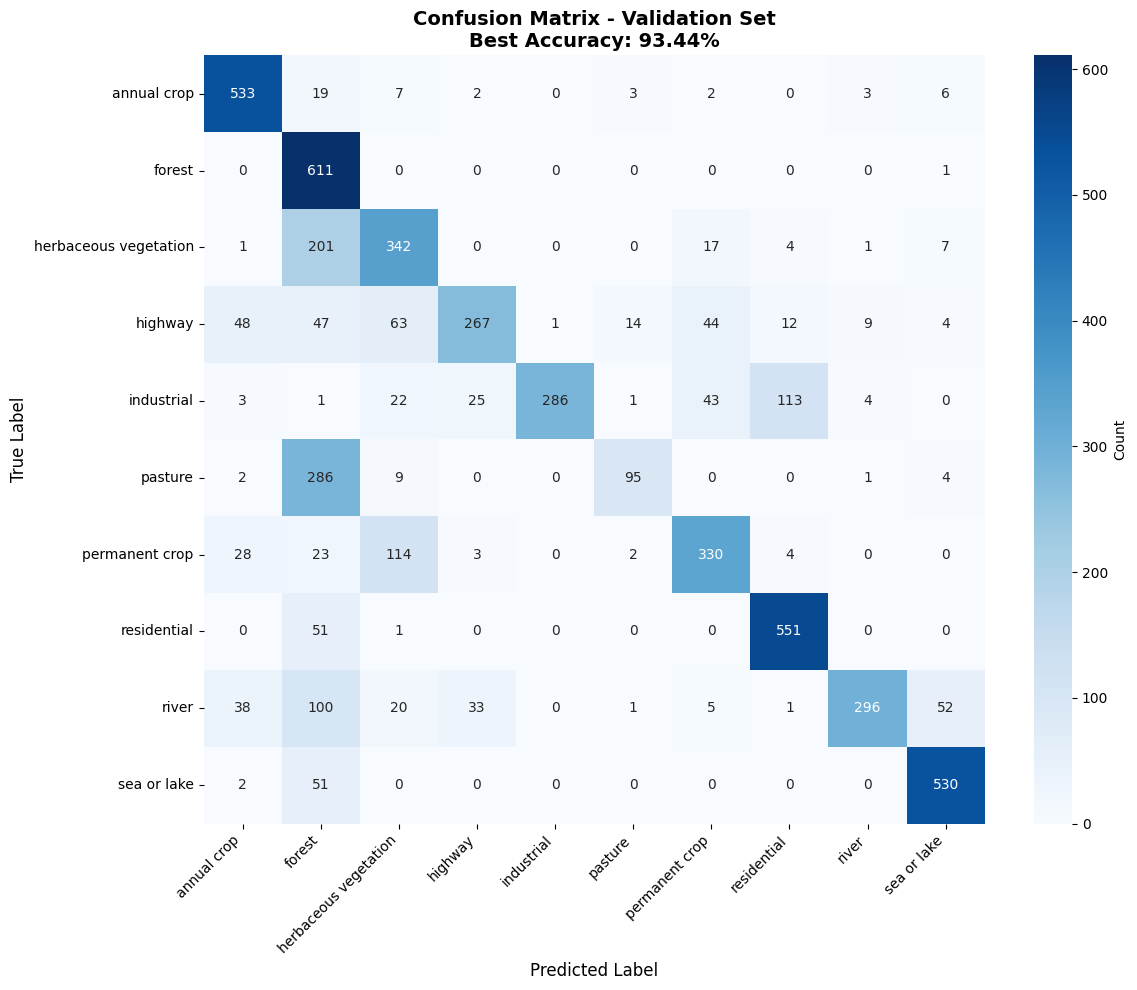


PER-CLASS ACCURACY
annual crop                   :  92.70% ( 533/ 575)
forest                        :  99.84% ( 611/ 612)
herbaceous vegetation         :  59.69% ( 342/ 573)
highway                       :  52.46% ( 267/ 509)
industrial                    :  57.43% ( 286/ 498)
pasture                       :  23.93% (  95/ 397)
permanent crop                :  65.48% ( 330/ 504)
residential                   :  91.38% ( 551/ 603)
river                         :  54.21% ( 296/ 546)
sea or lake                   :  90.91% ( 530/ 583)
Overall Accuracy: 93.44%


In [37]:
# Generate Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions on validation set
supervised_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = supervised_model(images)
        _, predicted = outputs.max(1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=ID_CLASS_NAMES, 
            yticklabels=ID_CLASS_NAMES,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - Validation Set\nBest Accuracy: {best_val_acc:.2f}%', 
          fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate per-class accuracy
class_correct = cm.diagonal()
class_total = cm.sum(axis=1)
class_accuracy = 100.0 * class_correct / class_total

print("\n" + "="*60)
print("PER-CLASS ACCURACY")
print("="*60)
for i, class_name in enumerate(ID_CLASS_NAMES):
    print(f"{class_name:30s}: {class_accuracy[i]:6.2f}% ({class_correct[i]:4d}/{class_total[i]:4d})")
print("="*60)
print(f"Overall Accuracy: {best_val_acc:.2f}%")
print("="*60)